In [11]:
#load rpy2 magic
%load_ext rpy2.ipython

# to switch off warning messages
import warnings
warnings.filterwarnings("ignore")

# make default cell width 85% of available screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# show multiple tables in python shells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# load R libraries & functions
%R options(warn=-1)
%R library(RColorBrewer)
%R library(ggplot2)
%R library(gplots)
%R library(gridExtra)
%R library(ggrepel)
    
# load python modules
import glob
import re
import sys
import os
import rpy2.robjects as robjects
import CGAT.Database as DB
import sqlite3
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

db = "./csvdb"

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


R object with classes: ('list',) mapped to:
<ListVector - Python:0x7fc8c6855b48 / R:0x2d27788>
[FloatVector]
  warn: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7fc8c653c998 / R:0x55abb68>
[-1.000000]

array(['ggrepel', 'gridExtra', 'gplots', 'ggplot2', 'RColorBrewer',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'],
      dtype='|S12')

array(['ggrepel', 'gridExtra', 'gplots', 'ggplot2', 'RColorBrewer',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'],
      dtype='|S12')

array(['ggrepel', 'gridExtra', 'gplots', 'ggplot2', 'RColorBrewer',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'],
      dtype='|S12')

array(['ggrepel', 'gridExtra', 'gplots', 'ggplot2', 'RColorBrewer',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'],
      dtype='|S12')

array(['ggrepel', 'gridExtra', 'gplots', 'ggplot2', 'RColorBrewer',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'],
      dtype='|S12')

# **MEME-ChIP Report**
***
## **MEME**
- Searches for **novel** ungapped motifs in input sequences
- TOMTOM compares discovered motifs against database(s) of known motifs

In [12]:
%%R

# R functions
theme_notebook <- function(base_size=18, base_family="helvetica") {
                  (theme_set(theme_minimal(base_size=18))
                  + theme(plot.title = element_text(face="bold", size=20, hjust=0.5),
                             text = element_text(),
                             axis.title = element_text(face="bold",size = rel(1)),
                             axis.title.y = element_text(angle=90,vjust=2, size=20),
                             axis.title.x = element_text(vjust=-0.2, size=20),
                             axis.text = element_text(size=20),
                             axis.line = element_line(colour="black"),
                             axis.ticks = element_line(),
                             legend.key = element_rect(colour = NA),
                             legend.key.size= unit(0.5, "cm"),
                             legend.margin = unit(0.5, "cm"),
                             legend.text = element_text(size=14),
                             legend.title = element_text(size=16),
                             strip.text = element_text(size=18)
                             ))
}

# Set ggplot theme
theme_set(theme_notebook(base_size=18))
Palette <- c("#E69F00", "#0072B2", "#D55E00", "#009E73", "#56B4E9",  "#999999", "#F0E442")

In [97]:
def motif_lookup(db):
    
    with open("./pipeline.ini", "r") as o:
        for line in o:
            a = re.findall("^motif_db=.*", line)
            if len(a) > 0:
                dbs = a[0].split(",")

    df1 = {}
    df2 = {}
    df3 = {}
    
    transfac = [x for x in dbs if "transfac" in x]
    jaspar = [x for x in dbs if "JASPAR" in x]
    uniprobe = [x for x in dbs if "uniprobe" in x]
    hocomoco = [x for x in dbs if "HOCOMOCO" in x]
    chen = [x for x in dbs if "chen" in x]

    n = 0
    for i in [transfac, jaspar, uniprobe]:
        n = n + 1
        if n == 1:
            db_name = "transfac"
        if n == 2:
            db_name = "jaspar"
        if n == 3:
            db_name = "uniprobe"
        meme = ''.join(i).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[2]
                    df1[motif_name] = motif_id

        if n == 1:
            dfs = pd.DataFrame.from_dict(df1, orient="index")
            dfs.columns = ["motif_id"]
            dfs["motif_name"] = dfs.index.values
            dfs.reset_index(inplace=True, drop=True)
            dfs["database"] = db_name
        else:
            dfs1 = pd.DataFrame.from_dict(df1, orient="index")
            dfs1.columns = ["motif_id"]
            dfs1["motif_name"] = dfs1.index.values
            dfs1.reset_index(inplace=True, drop=True)
            dfs1["database"] = db_name
            
            dfs = dfs.append(dfs1)

    if len(hocomoco) > 0:
        meme = ''.join(hocomoco).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(".")
                    motif[0].split(".")
                    motif_name = str(motif[0]).replace("MOTIF ", "")
                    motif_suffix = '.'.join(motif[1:3])
                    motif_id = '.'.join([motif_name, motif_suffix])
                    df2[motif_name] = motif_id

        df2 = pd.DataFrame.from_dict(df2, orient="index")
        df2.columns = ["motif_id"]
        df2["motif_name"] = df2.index.values
        df2.reset_index(inplace=True, drop=True)
        df2["database"] = "hocomoco"
    
    if len(chen) > 0:
        meme = ''.join(chen).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[1]
                    df3[motif_name] = motif_id
                
        df3 = pd.DataFrame.from_dict(df3, orient="index")
        df3.columns = ["motif_id"]
        df3["motif_name"] = df3.index.values
        df3.reset_index(inplace=True, drop=True)
        df3["database"] = "chen"
    
    # merge all dfs
    df = dfs.append([df2, df3])
    
    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("motif_table", connect, if_exists="replace", index=False)

    return df

df = motif_lookup(db)

In [94]:
def meme_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples
        
    if len(conditions)==0: # allow just one condition
        conditions = [None]

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

            m = re.findall("^nmotif=.*", line)
            if len(m) > 0:
                m = m[0].lstrip("nmotif=")
                no_motifs = range(1, int(m)+1)

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:

                    # get corresponding meme e_values for discovered motifs from meme.txt
                    if c != None:
                        table = '_'.join([name, c, str(peaks), str(width)]) + "_Meme_tomtom"
                        meme_out = "meme.chip.dir/" + '_'.join([name, c]) + "." + '.'.join([str(peaks), str(width)]) + "/meme_out/meme.txt"
                    else:
                        table = '_'.join([name, str(peaks), str(width)]) + "_Meme_tomtom"
                        meme_out = "meme.chip.dir/" + name + "." + '.'.join([str(peaks), str(width)]) + "/meme_out/meme.txt"
                    
                    if os.path.exists(meme_out):
                        n = 0
                        with open(meme_out, "r") as open_meme:
                            for line in open_meme:
                                motif = re.findall("^MOTIF.*", line)
                                if len(motif) > 0:
                                    n = n + 1
                                    nmotif = str(motif[0].split(" ")[0:3][-1])
                                e_val = re.findall("E-value.*", str(motif))
                                if len(e_val) > 0:
                                    e_value = e_val[0].split(" ")[-1].replace("'", "").strip("]")

                                if (len(e_val)>0) & (len(motif) > 0):
                                    df = pd.DataFrame([nmotif, e_value]).transpose()
                                    df.columns = ["query_id", "meme_evalue"]
                                    df["run"] = str(table).rstrip("_Meme_tomtom")
                                    dfs.append(df)

    c = 0
    for df in dfs:
        c = c + 1
        if c ==1:
            motifs = df
        else:
            motifs = motifs.append(df)

    motifs = motifs.drop_duplicates()
    
    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("meme_motifs", connect, if_exists="replace", index=False)
                    
    return motifs

meme = meme_summary(db)

In [95]:
def memechip_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples
        
    if len(conditions)==0: # allow just one condition
        conditions = [None]

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

            m = re.findall("^nmotif=.*", line)
            if len(m) > 0:
                m = m[0].lstrip("nmotif=")
                no_motifs = range(1, int(m)+1)

    # get existing tables in db
    dbhandle = sqlite3.connect(db)
    cc = dbhandle.cursor()
    cc.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabs = cc.fetchall()
    tables = pd.DataFrame(tabs, columns=["tables"])

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    
                    # get corresponding meme e_values for discovered motifs from meme.txt
                    if c != None:
                        table = '_'.join([name, c, str(peaks), str(width)]) + "_Meme_tomtom"
                    else:
                        table = '_'.join([name, str(peaks), str(width)]) + "_Meme_tomtom"

                    if tables["tables"].str.contains(table).any():
                        n = 0
                        for query in no_motifs:
                            n = n + 1
                            statement = '''select a.query_id, a.query_consensus, a.target_id, 
                                        b.motif_name, b.database, a.e_value as tomtom_evalue, a.orientation
                                        from %(table)s a, motif_table b where a.target_id = b.motif_id 
                                        and a.query_id = %(query)s 
                                        order by e_value asc''' % locals()

                            df = DB.fetch_DataFrame(statement, db)
                            df = df.drop_duplicates()

                            df["run"] = str(table).rstrip("_Meme_tomtom")
                            df["DESeq2_comparison"] = df["run"].apply(lambda x: x.split("_")[0])
                            
                            if c != None: 
                                df["condition"] = df["run"].apply(lambda x: x.split("_")[1])
                                df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[2])
                                df["window"] = df["run"].apply(lambda x: x.split("_")[3])
                            else:
                                df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[1])
                                df["window"] = df["run"].apply(lambda x: x.split("_")[2])

                            if n == 1:
                                result = df
                            else:
                                result = result.append(df)

                        dfs.append(result)
                        
    c = 0
    for df in dfs:
        c = c + 1
        if c == 1:
            motifs = df
        else:
            motifs = motifs.append(df)
            
    motifs["motif_name"] = motifs["motif_name"].apply(lambda x: x.replace("_MOUSE", ""))
    
    return motifs

motifs = memechip_summary(db)

In [96]:
def analyse_meme(motifs, meme):

    # annotate dfs for merging
    motifs["merge"] = motifs.apply(lambda x: '_'.join([x.run, str(x.query_id)]), axis=1)
    meme["merge"] = meme.apply(lambda x: '_'.join([x.run, str(x.query_id)]), axis=1)

    meme.drop(["query_id", "run"], axis=1, inplace=True) # drop extra cols

    # merge dfs
    meme_chip = pd.merge(meme, motifs, how="inner", on="merge")
    meme_chip.drop_duplicates(inplace=True)

    meme_chip["meme_evalue"] = meme_chip["meme_evalue"].apply(lambda x: float(x)) # correct type
    meme_chip["settings"] = meme_chip["no_peaks"] + "_" + meme_chip["window"] # make column for plot annotations

    if len(meme_chip[meme_chip["meme_evalue"] < 0.05])==0:
        print "No significant motifs detected by MEME"
        meme_chip = None

    else:
        # subset on sig motifs & sig matches
        meme_chip = meme_chip[(meme_chip.tomtom_evalue < 0.05) & (meme_chip.meme_evalue < 0.05)].sort_values(["meme_evalue", "tomtom_evalue"], ascending=True)
        meme_chip = meme_chip[meme_chip["meme_evalue"] != 0]
        meme_chip = meme_chip[meme_chip["tomtom_evalue"] != 0]

    return meme_chip

meme_chip = analyse_meme(motifs, meme)

## Effect of MEME-ChIP Settings on MEME & TOMTOM

In [51]:
# make new df for plots
meme_evalue = meme_chip.copy(deep=True)
meme_evalue.index.name = None
meme_evalue.reset_index(inplace=True, drop=True)
meme_evalue = meme_evalue.drop_duplicates(["target_id", "motif_name", "merge"], keep="first")

In [52]:
%%R  -w 1200 -h 400 -i meme_evalue

# meme_chip <- read.csv("meme_chip_summary.txt", sep="\t", row.names=1)

a <- ggplot(meme_evalue, aes(y=-log10(tomtom_evalue), x=-log10(meme_evalue), shape=factor(query_id), alpha=condition, colour=database)) +
        geom_jitter(size=3) + 
        scale_alpha_discrete(range=c(0.4, 1)) +
        facet_grid(settings ~ DESeq2_comparison) +
        theme(legend.position="bottom", legend.direction="horizontal")
        
b <- ggplot(meme_evalue, aes(y=-log10(meme_evalue), x=window, fill=no_peaks)) + 
        geom_boxplot(aes(alpha=meme_evalue), position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Meme motif discovery", x="Peak width")
        
c <- ggplot(meme_evalue, aes(y=-log10(tomtom_evalue), x=window, fill=no_peaks)) + 
        geom_boxplot(aes(alpha=meme_evalue), position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Tomtom motif comparison", x="Peak width")

In [53]:
meme_motif_no = meme_evalue.groupby(["run", "window", "no_peaks"]).agg({"motif_name":"count"})
meme_motif_no.reset_index(inplace=True)

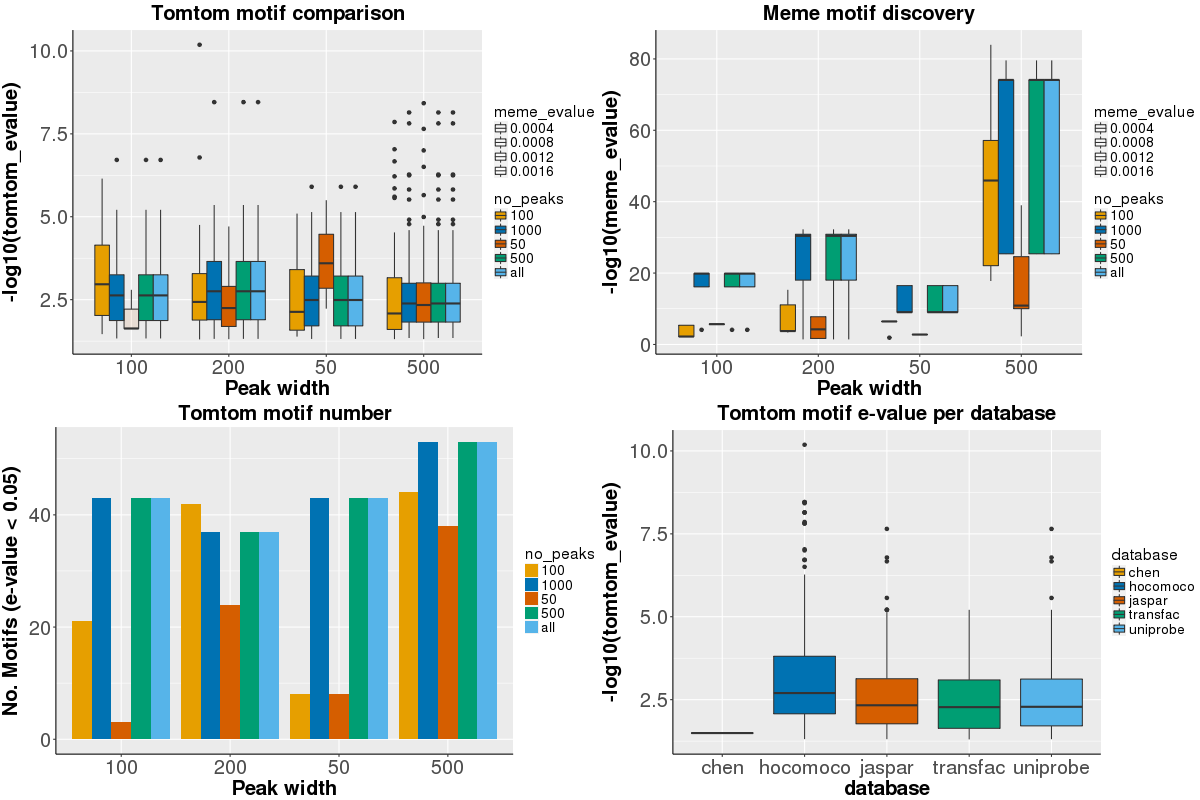

In [54]:
%%R -i meme_motif_no,meme_chip -w 1200 -h 800

# meme_motif_no <- meme_motif_no[order(meme_motif_no$motif_name, descending=TRUE), ]
d <- ggplot(meme_motif_no, aes(y=motif_name, x=window, fill=no_peaks)) + 
        geom_bar(stat="identity", position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Tomtom motif number", x="Peak width", y="No. Motifs (e-value < 0.05)")# +
#         scale_x_discrete(limits=unique(meme_motif_no$window))
        
e <- ggplot(meme_chip, aes(y=-log10(tomtom_evalue), x=database, fill=database)) + 
        geom_boxplot() +
        scale_fill_manual(values=Palette) +
        labs(title="Tomtom motif e-value per database")
        
grid.arrange(c, b, d, e, ncol=2, nrow=2)

***
<br>

## MEME-ChIP Summary
* For simplicity results from all MEME-ChIP runs are aggregated
    * TOMTOM & MEME e-values are averaged across runs
    * No. motif occurances between runs and databases is counted
    * All MEME motifs have an e-value < 0.05
* This is to provide an overview of the data, do not use for downstream analysis

In [56]:
# aggregate data
meme_summary = meme_chip.groupby(["target_id", "motif_name", "query_id", "DESeq2_comparison"]).agg({"tomtom_evalue":"mean", "meme_evalue":"mean", "run":"count", "database":"count"})
meme_summary.reset_index(inplace=True)

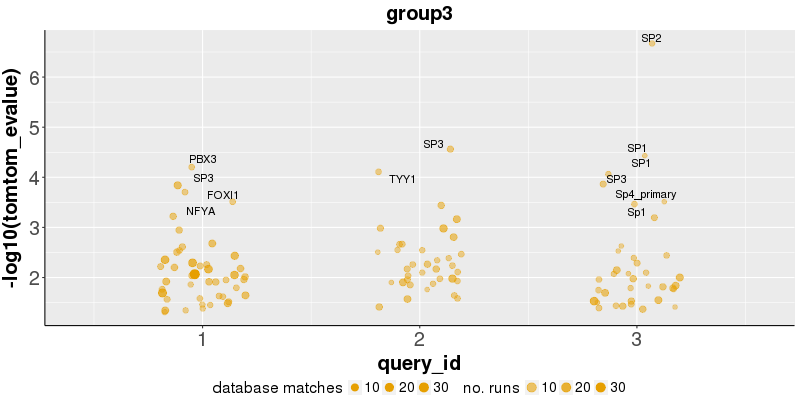

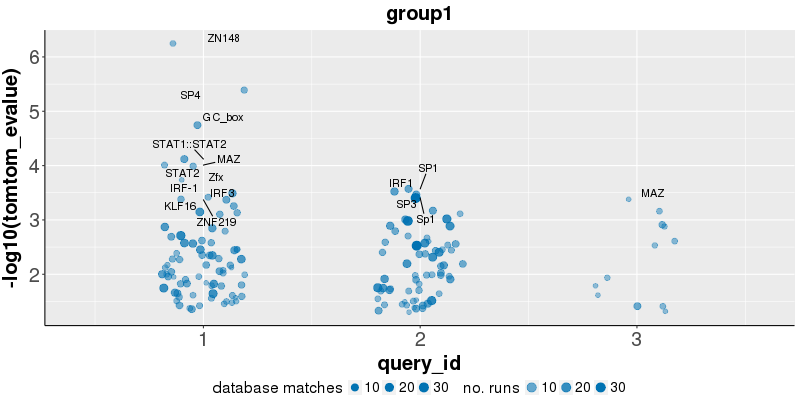

In [70]:
%%R -i meme_summary -w 800 -h 400

n = 0
for (comp in unique(meme_summary$DESeq2_comparison)){
    n = n + 1
    df <- subset(meme_summary, DESeq2_comparison == comp)

    p <- ggplot(df, aes(y=-log10(tomtom_evalue), x=query_id, alpha=run)) +
            geom_point(aes(size=database), position=position_jitterdodge(), colour=Palette[[n]]) + 
            scale_size(range=c(2,4), name="database matches") +
            scale_alpha(range=c(0.4,1), name="no. runs") +
            scale_shape_manual(values=c(16, 17, 15), name="meme motif") +
            geom_text_repel(
                data=df[-log10(df$tomtom_evalue) > 
                          quantile(-log10(df$tomtom_evalue), 0.9, na.rm=T), ], 
                aes(label=motif_name), colour="black", alpha=1, position=position_jitterdodge()) +
            theme(legend.position="bottom", legend.direction="horizontal") +
            guides(color=guide_legend(override.aes=list(size=4)), alpha=guide_legend(override.aes=list(size=4))) +
            labs(title=comp)
    
    grid.arrange(p, ncol=1, nrow=1)
}

## MEME & TOMTOM Results for Each Run & Sample
* Multiple database hits for the same motif discovered by MEME are merged (TOMTOM e-values are averaged)

In [98]:
# make new df for plot
meme_graph = meme_chip.copy(deep=True)

# count occurnaces of the same motif matching a TF in many databases
# average tomtom_evalue in these instances
meme_graph = meme_graph.groupby(["merge", "target_id", "motif_name", "query_id","orientation", "run", "DESeq2_comparison", "settings"]).agg({"database":"count", "meme_evalue":"min", "tomtom_evalue":"mean"})
meme_graph.reset_index(inplace=True)

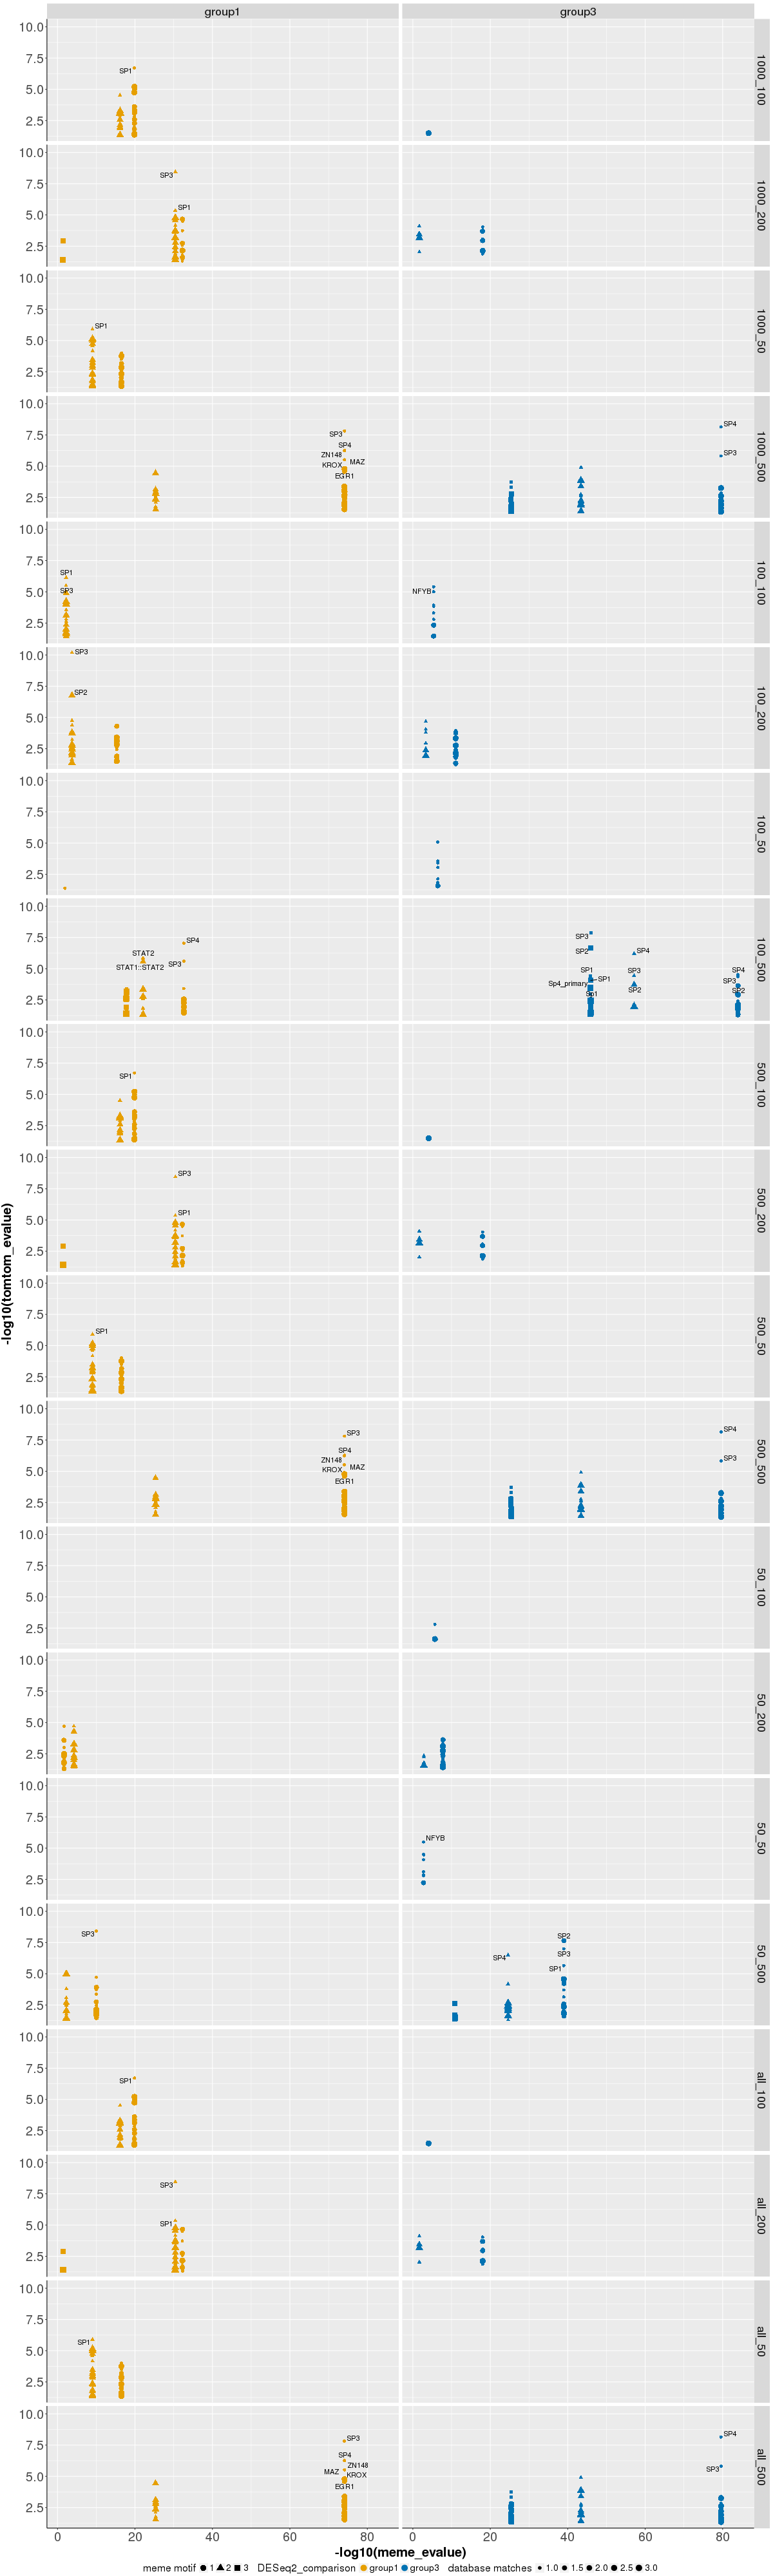

In [82]:
%%R -i meme_graph -w 1200 -h 4000

ggplot(meme_graph, aes(y=-log10(tomtom_evalue), x=-log10(meme_evalue), shape=factor(query_id), colour=DESeq2_comparison)) +
    geom_jitter(aes(size=database)) + 
    scale_size(range=c(2,4), name="database matches") +
    scale_shape_manual(values=c(16, 17, 15), name="meme motif") +
    geom_text_repel(data=meme_graph[-log10(meme_graph$"meme_evalue") > 
                                   quantile(-log10(meme_graph$"meme_evalue"), 0.8, na.rm=T) &
                                   -log10(meme_graph$"tomtom_evalue") > 
                                   quantile(-log10(meme_graph$"tomtom_evalue"), 0.8, na.rm=T) |#, ], 
                                   -log10(meme_graph$"meme_evalue") > quantile(-log10(meme_graph$"meme_evalue"), 0.95, na.rm=T)  &
                                   -log10(meme_graph$"tomtom_evalue") > 
                                   quantile(-log10(meme_graph$"tomtom_evalue"), 0.9, na.rm=T) |
                                   -log10(meme_graph$"tomtom_evalue") > quantile(-log10(meme_graph$"tomtom_evalue"), 0.95, na.rm=T), ], 
                    aes(y=-log10(tomtom_evalue), x=-log10(meme_evalue), label=motif_name), colour="black") +
    facet_grid(settings ~ DESeq2_comparison) +
    theme(legend.position="bottom", legend.direction="horizontal") +
    scale_colour_manual(values=Palette) +
    guides(color=guide_legend(override.aes=list(size=4))) +
    guides(shape=guide_legend(override.aes=list(size=4)))

<br>
### Top Database Matches per MEME Motif 
* All discovered motifs have e-value < 0.05
* Multiple database matches for MEME motifs are grouped by TF name & TOMTOM e-values averaged

In [75]:
# make extra cols for annotation
meme_graph["width"] = meme_graph["settings"].apply(lambda x: "width_" + x.split("_")[1])
meme_graph["peaks"] = meme_graph["settings"].apply(lambda x: "npeaks_" + x.split("_")[0])

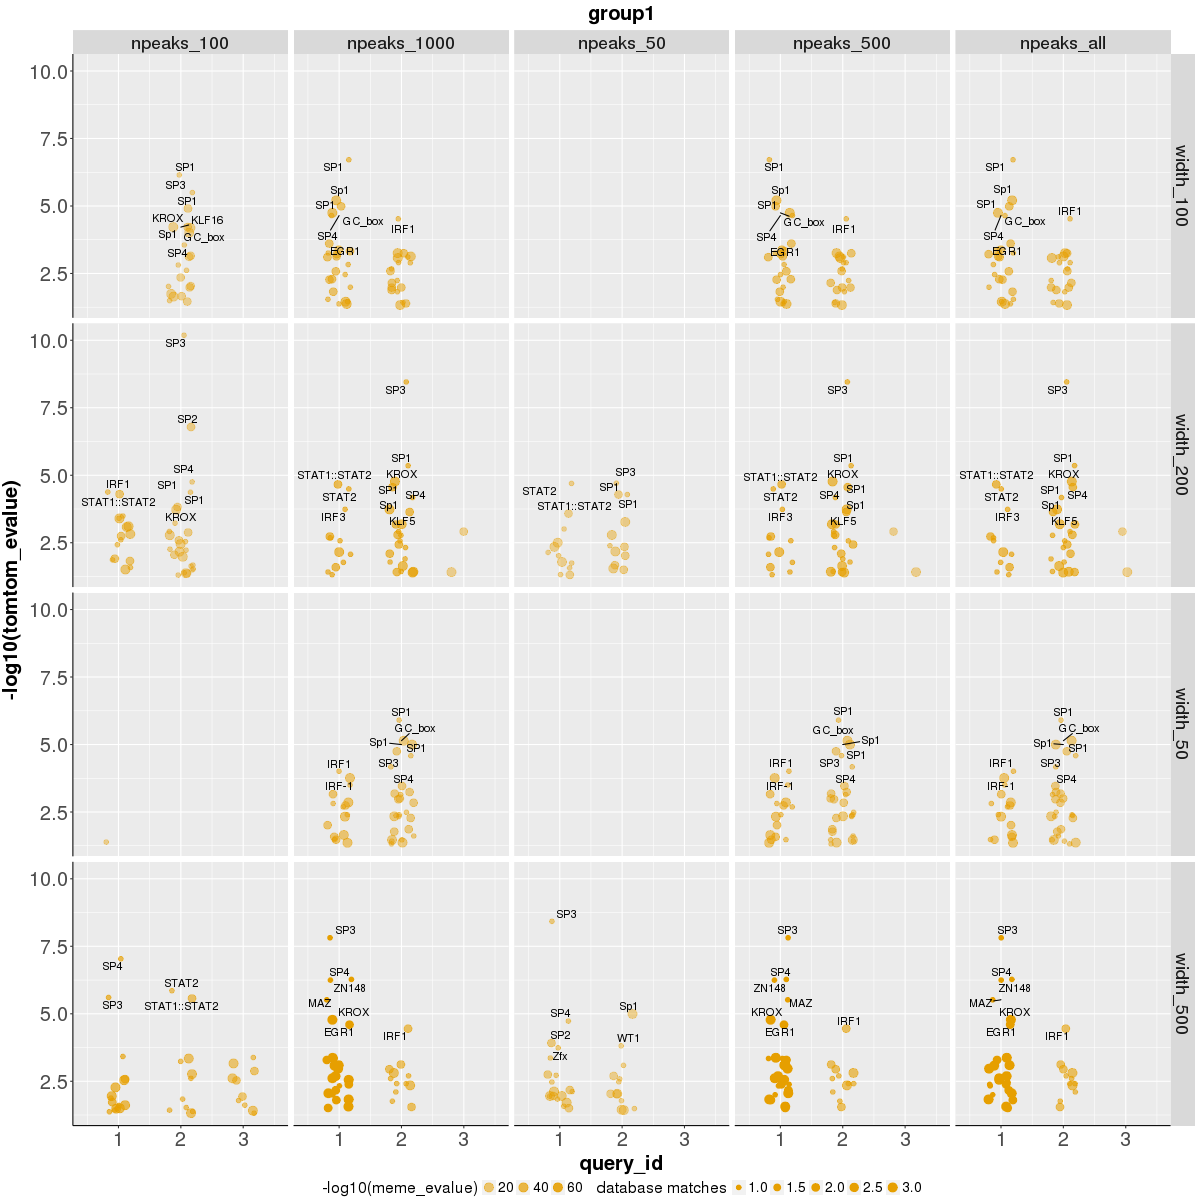

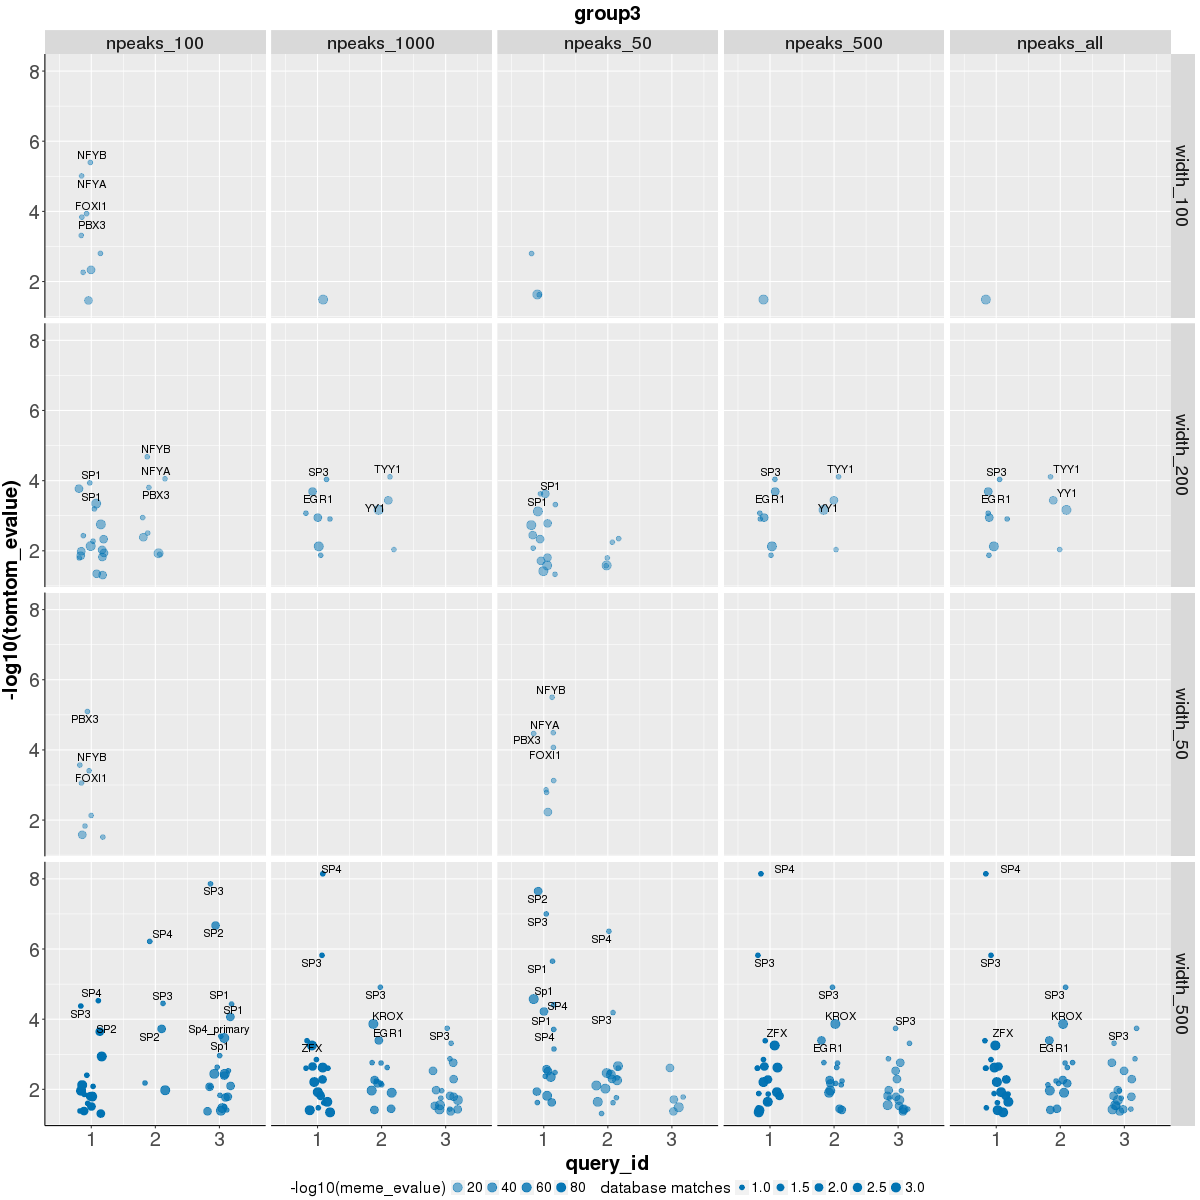

In [80]:
%%R -i meme_graph -w 1200 -h 1200

n = 0
for (comp in unique(meme_graph$DESeq2_comparison)){
    n = n + 1
    df <- subset(meme_graph, DESeq2_comparison == comp)

    p <- ggplot(df, aes(y=-log10(tomtom_evalue), x=query_id, alpha=-log10(meme_evalue))) +
        geom_point(aes(size=database), position=position_jitterdodge(), colour=Palette[[n]]) + 
        scale_size(range=c(2,4), name="database matches") +
        scale_alpha(range=c(0.4,1)) +
        geom_text_repel(data=df[-log10(df$"tomtom_evalue") > 
                                       quantile(-log10(df$"tomtom_evalue"), 0.8, na.rm=T), ], 
                        aes(y=-log10(tomtom_evalue), x=query_id, label=motif_name), colour="black", alpha=1) +
        facet_grid(width ~ peaks) +
        theme(legend.position="bottom", legend.direction="horizontal") +
#         scale_colour_manual(values=Palette) +
        guides(color=guide_legend(override.aes=list(size=4))) +
        guides(alpha=guide_legend(override.aes=list(size=4)))  +
        labs(title=comp)
    
    grid.arrange(p, ncol=1, nrow=1)
}

<br>
### Top TF Hits for Discovered Motifs 
- For significant motifs the top 5 significant TF matches are shown

In [54]:
tfs = meme_chip.groupby(["merge", "query_id", "DESeq2_comparison", "meme_evalue", "tomtom_evalue", "settings"])["motif_name"].unique()
tfs = pd.DataFrame(tfs)
tfs.reset_index(inplace=True)
tfs["motif_name"] = tfs["motif_name"].apply(lambda x:''.join(x))
tfs["query_id"] = tfs["query_id"].astype(str)
tfs = tfs.groupby("merge").head(5) # get top 5 db matches for each discovered motif

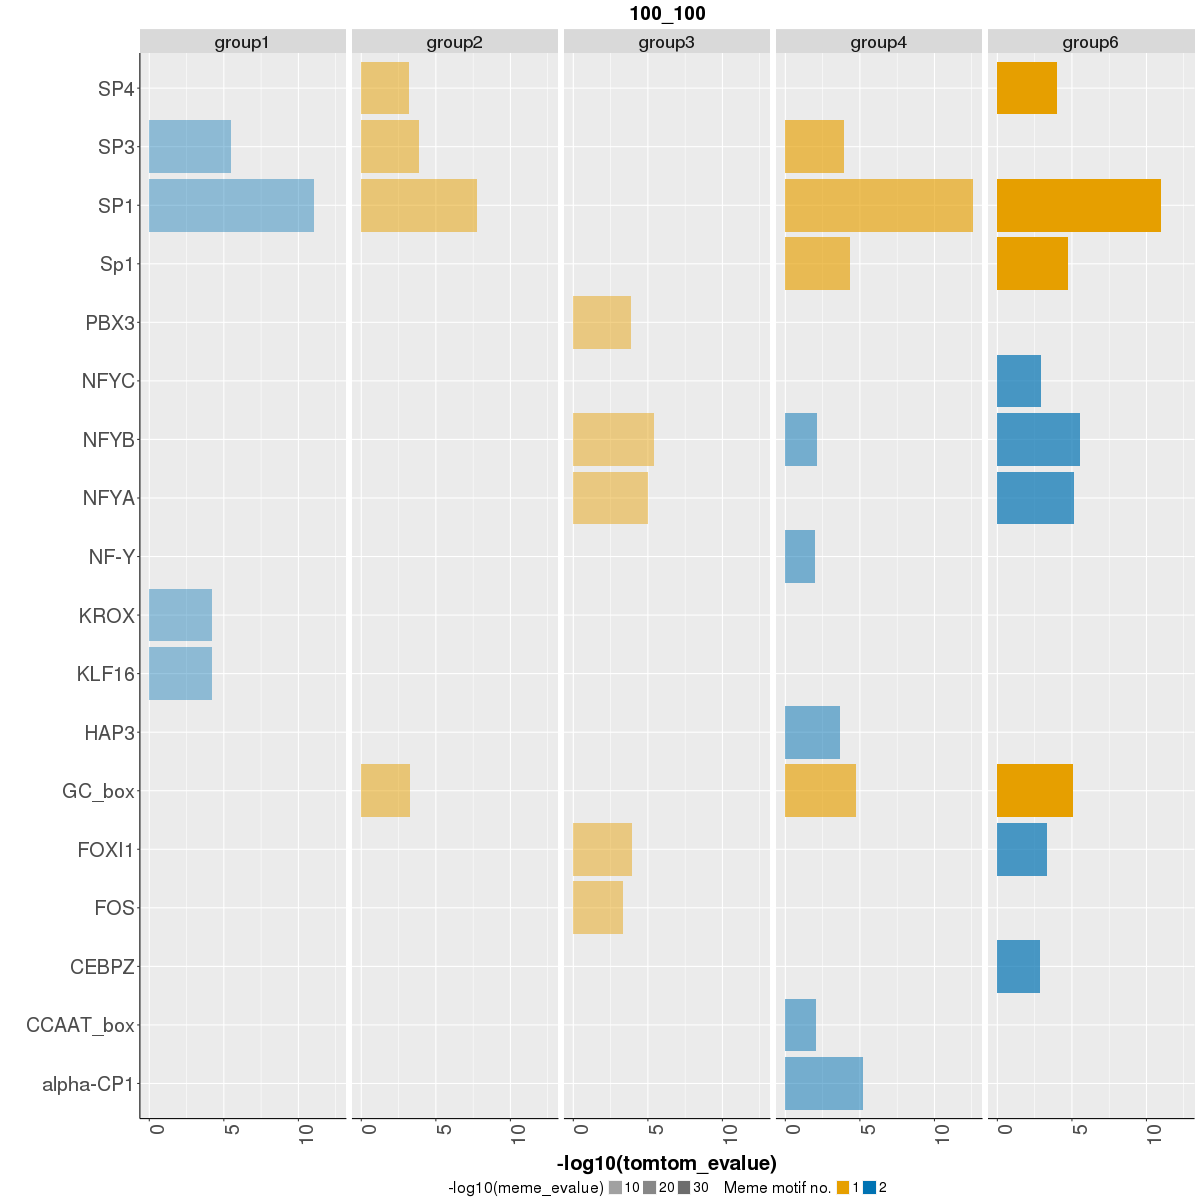

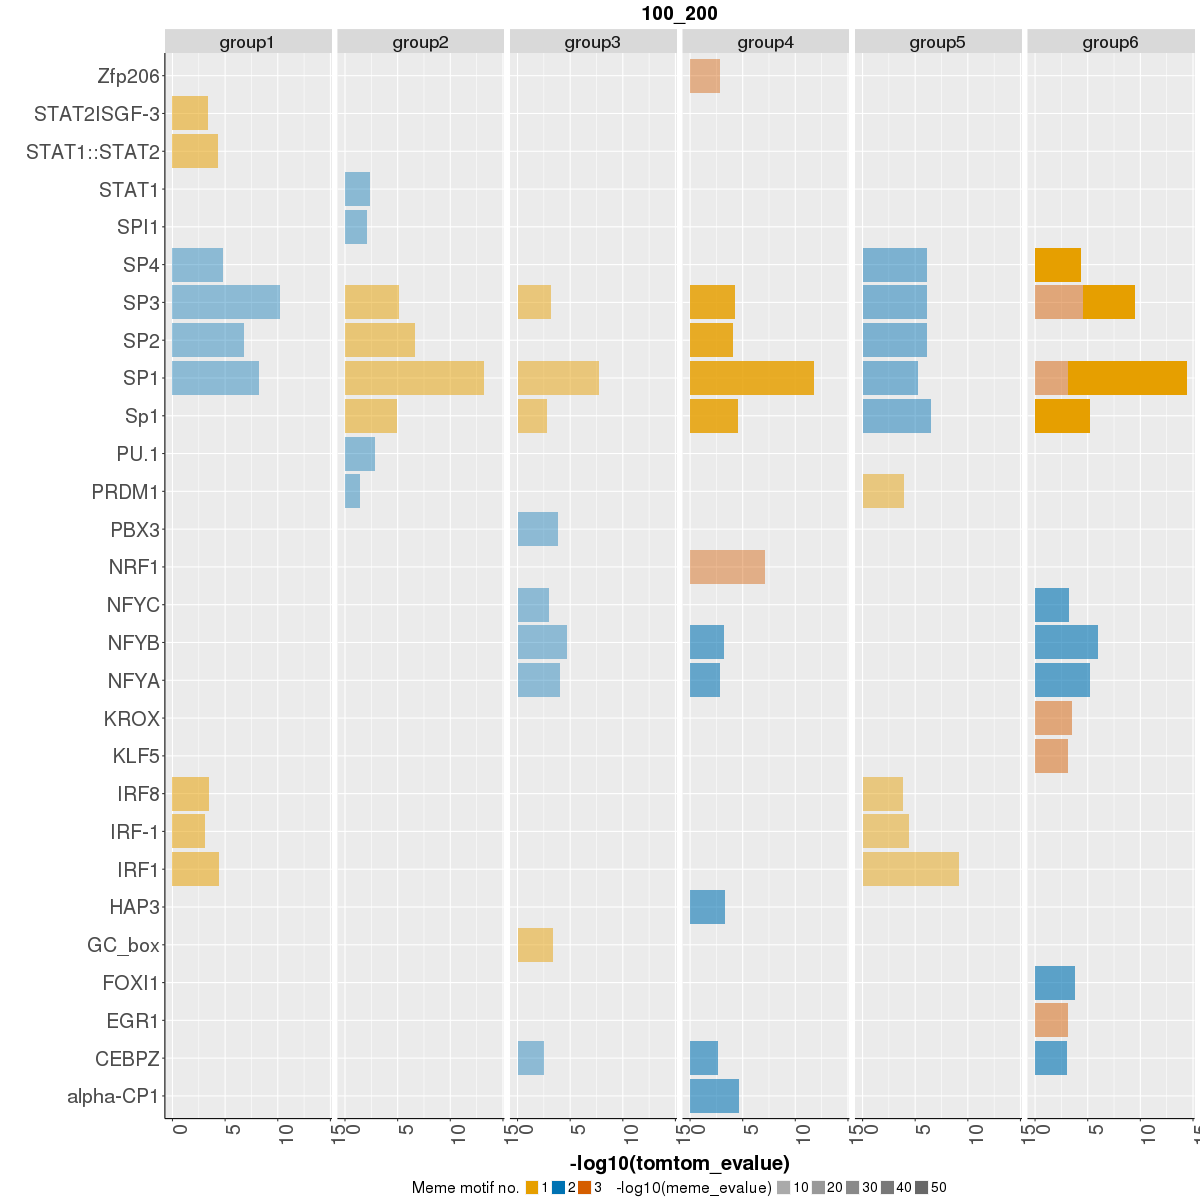

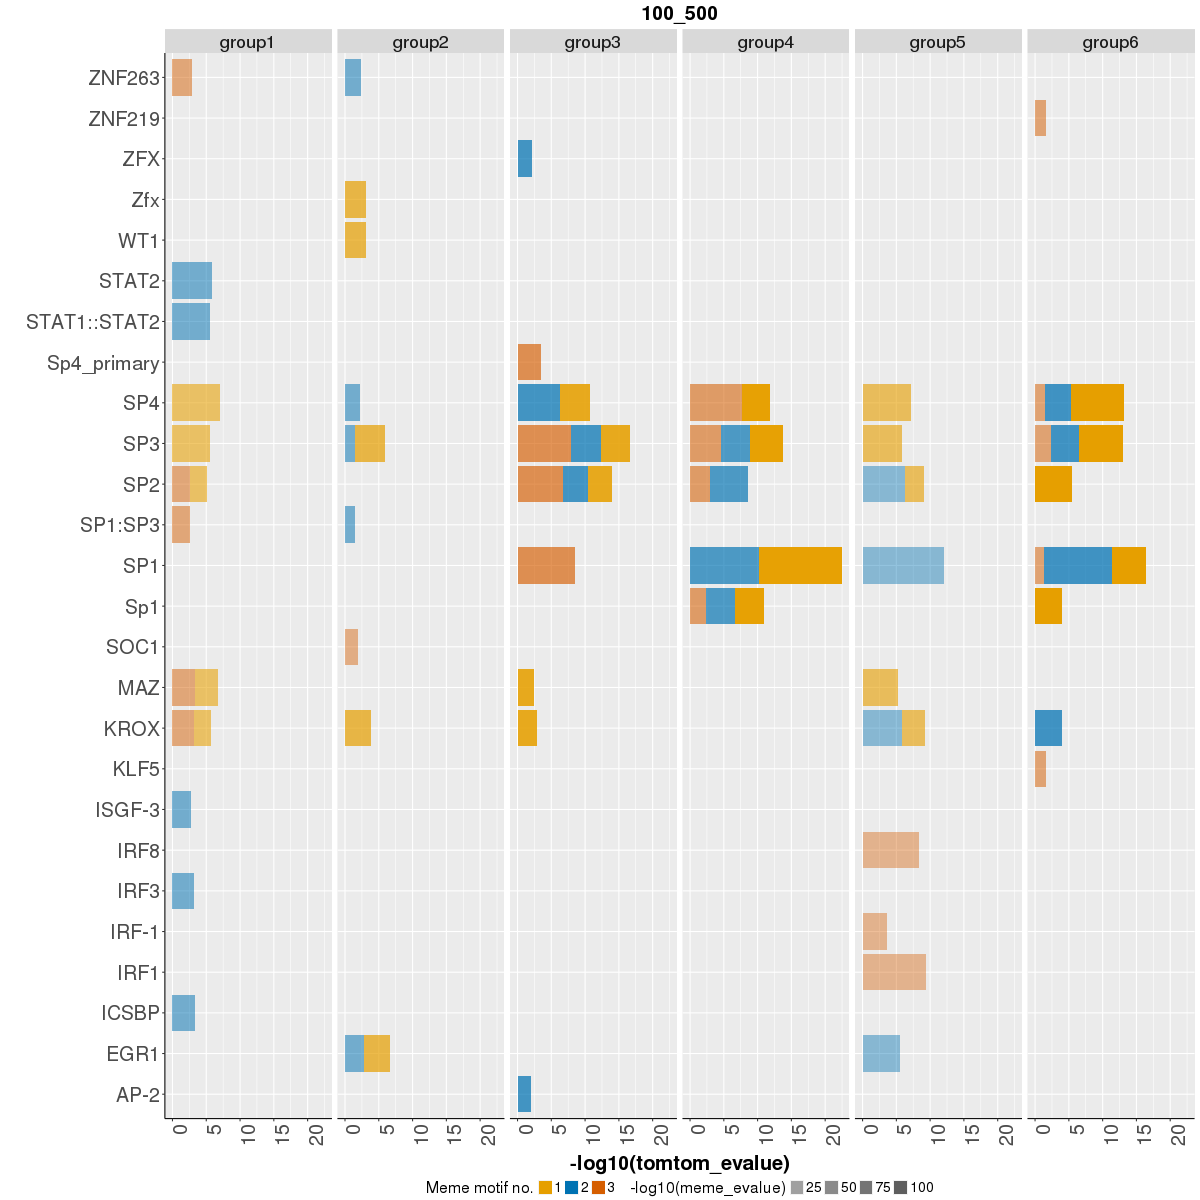

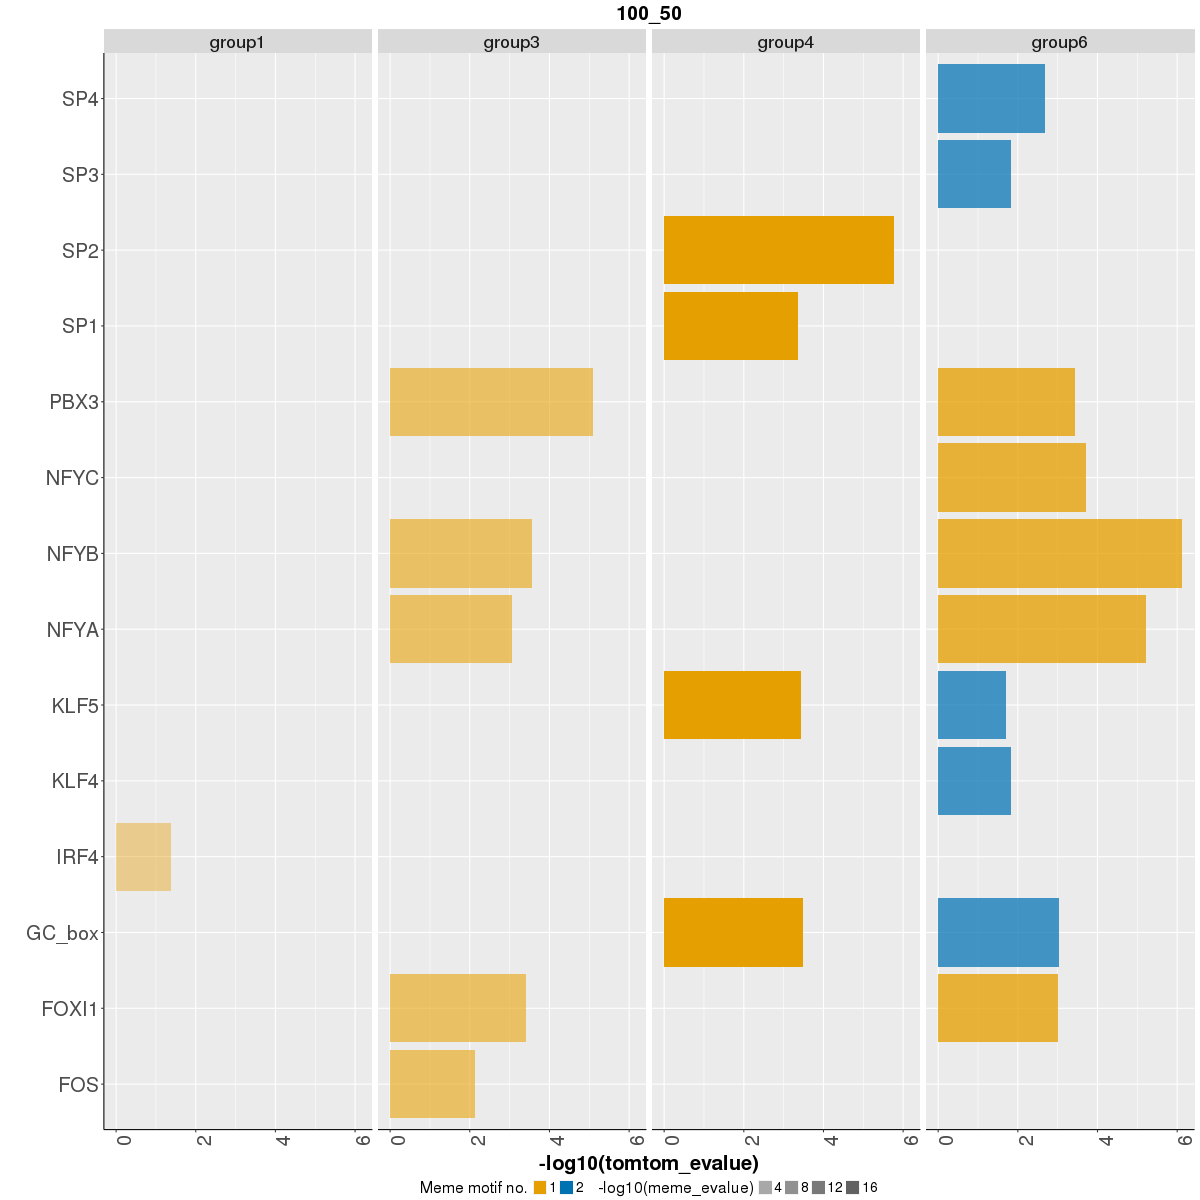

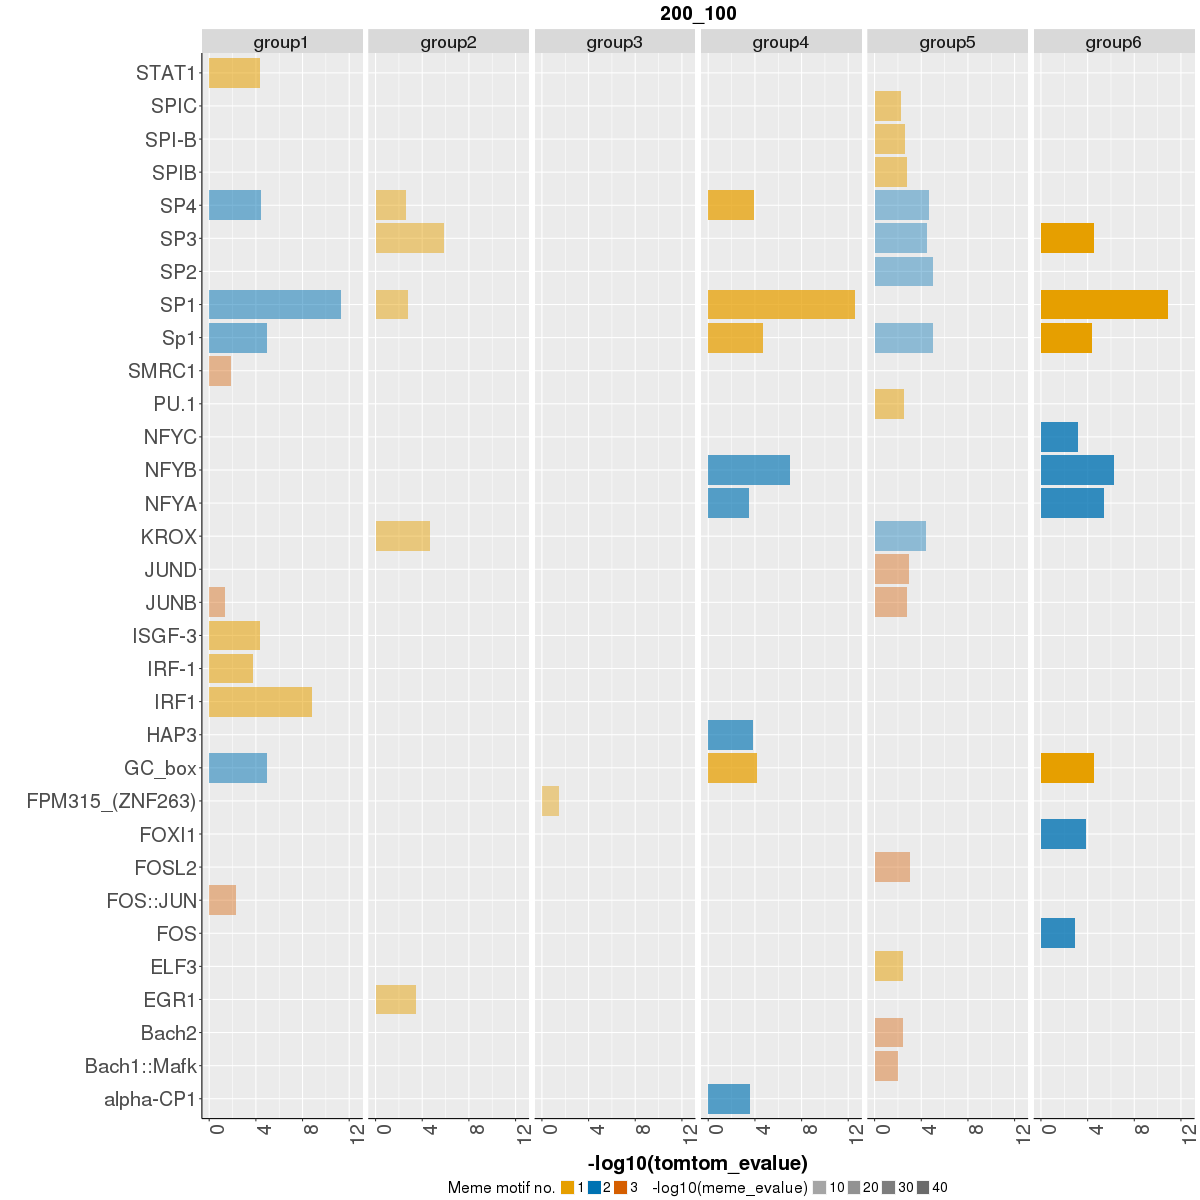

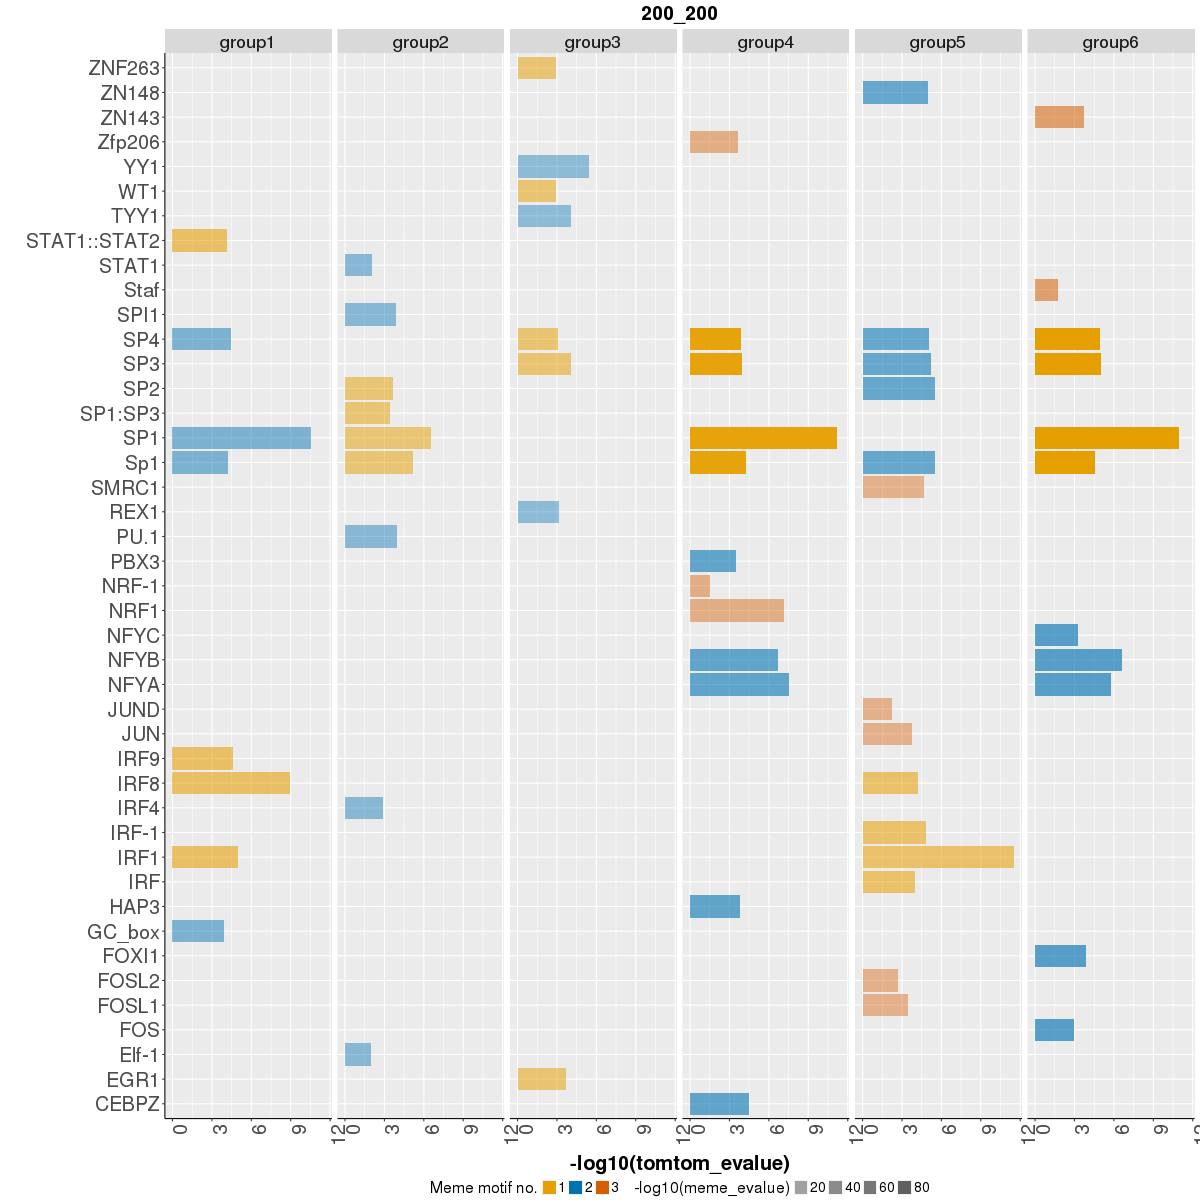

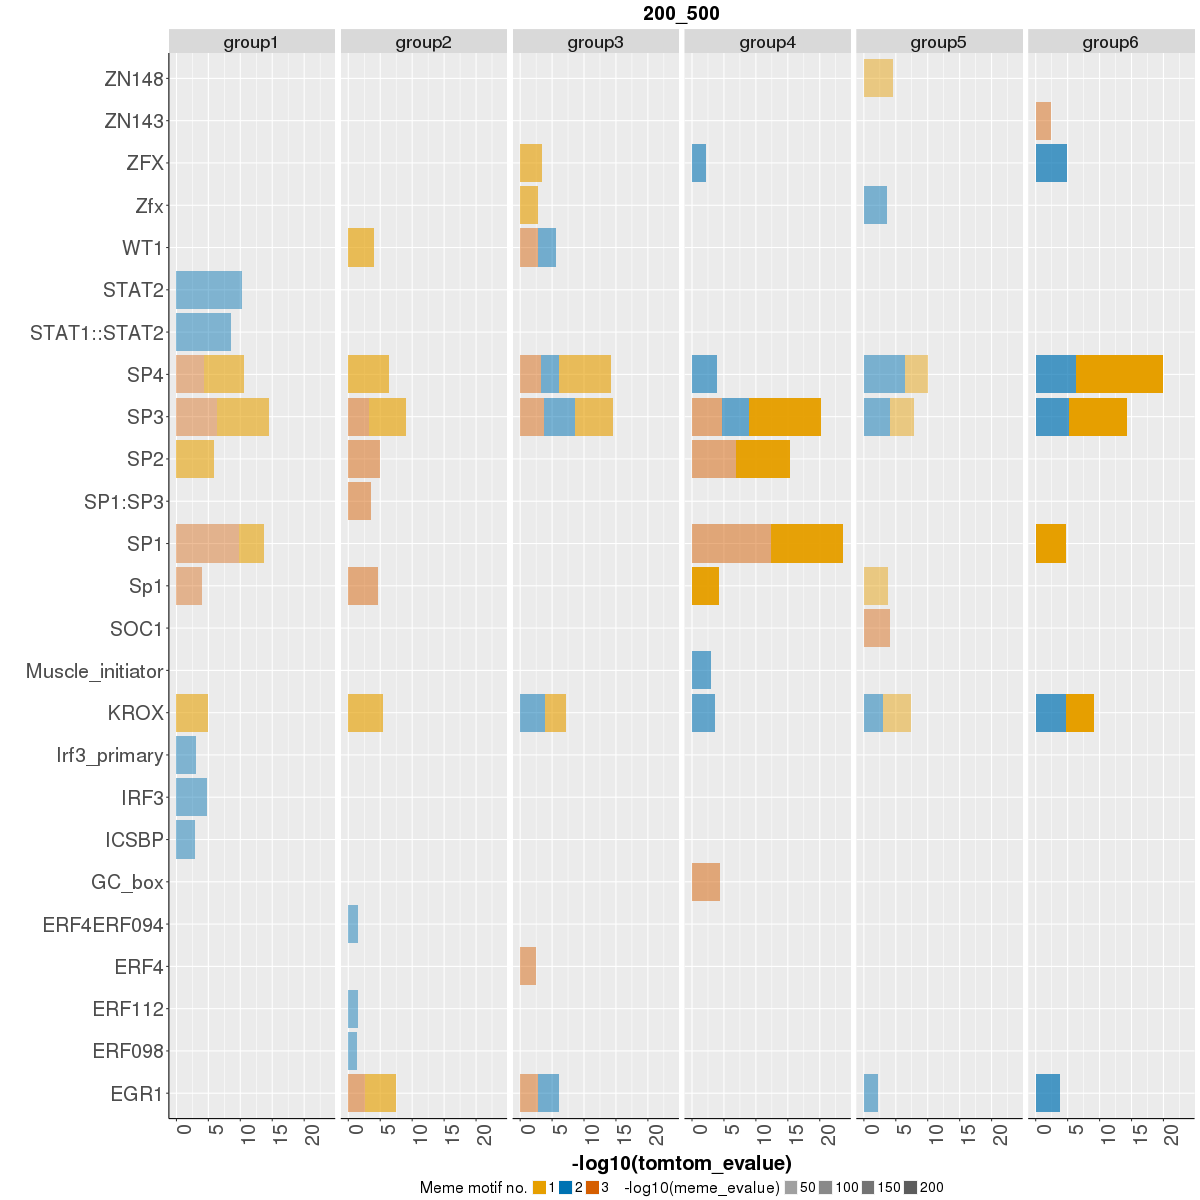

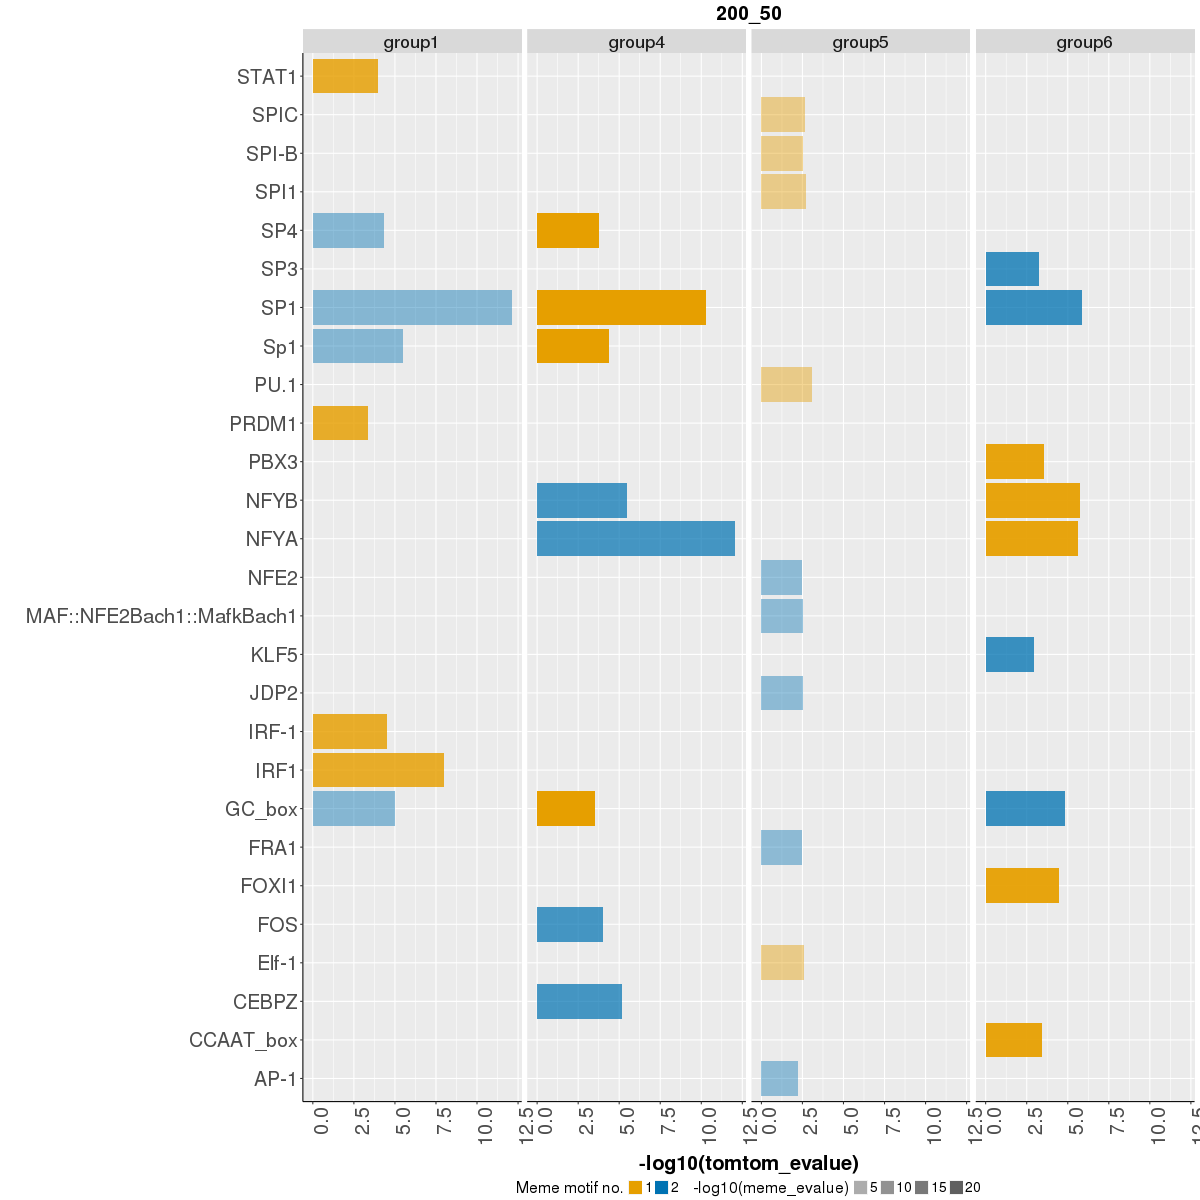

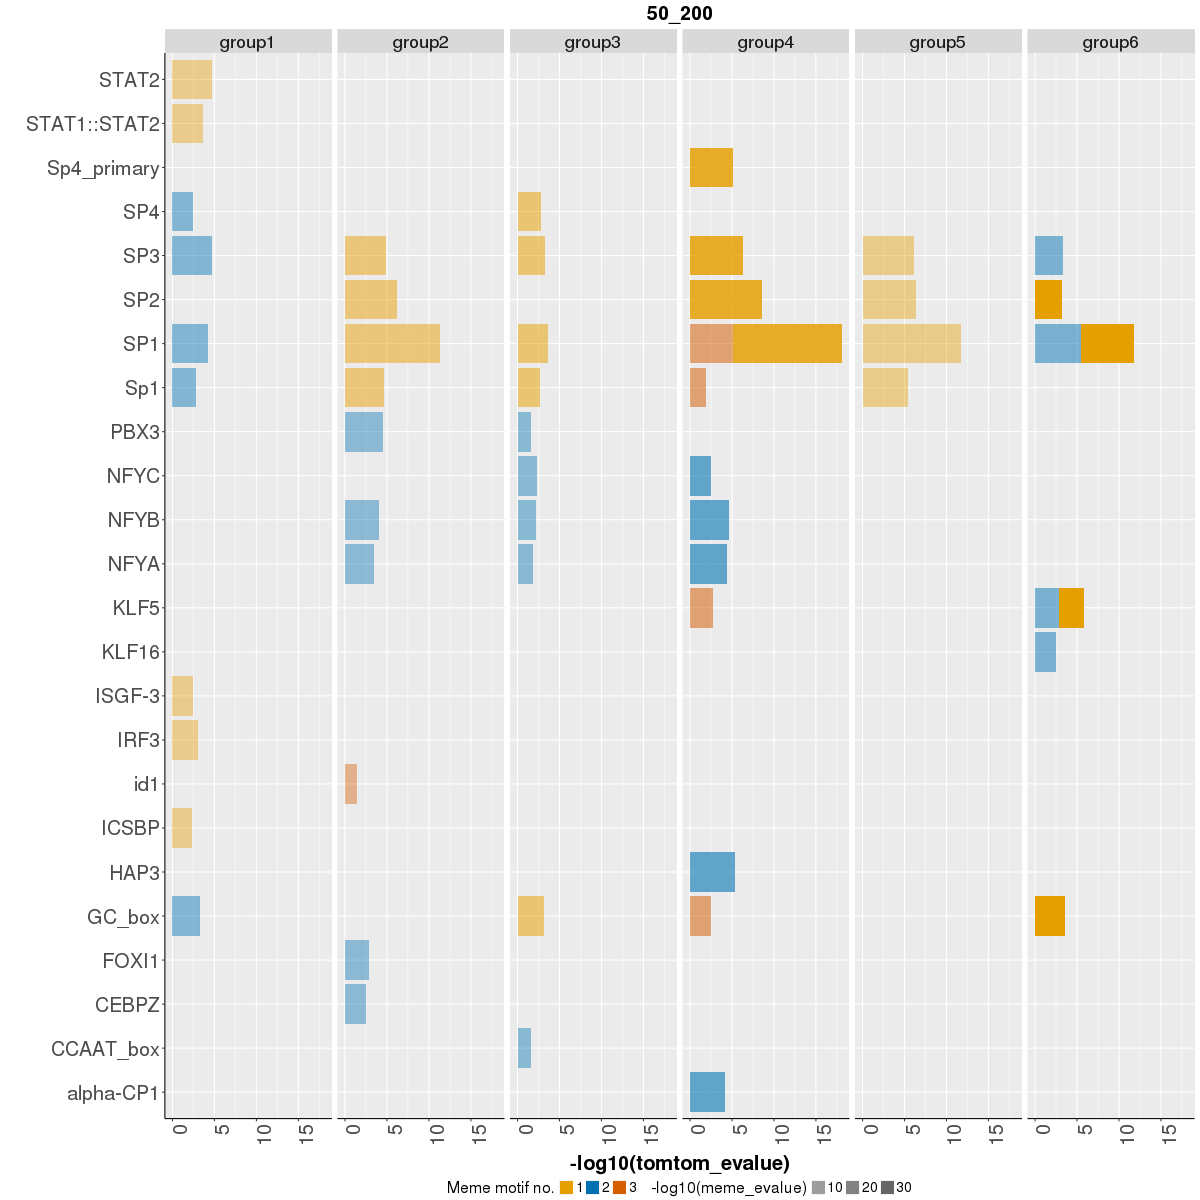

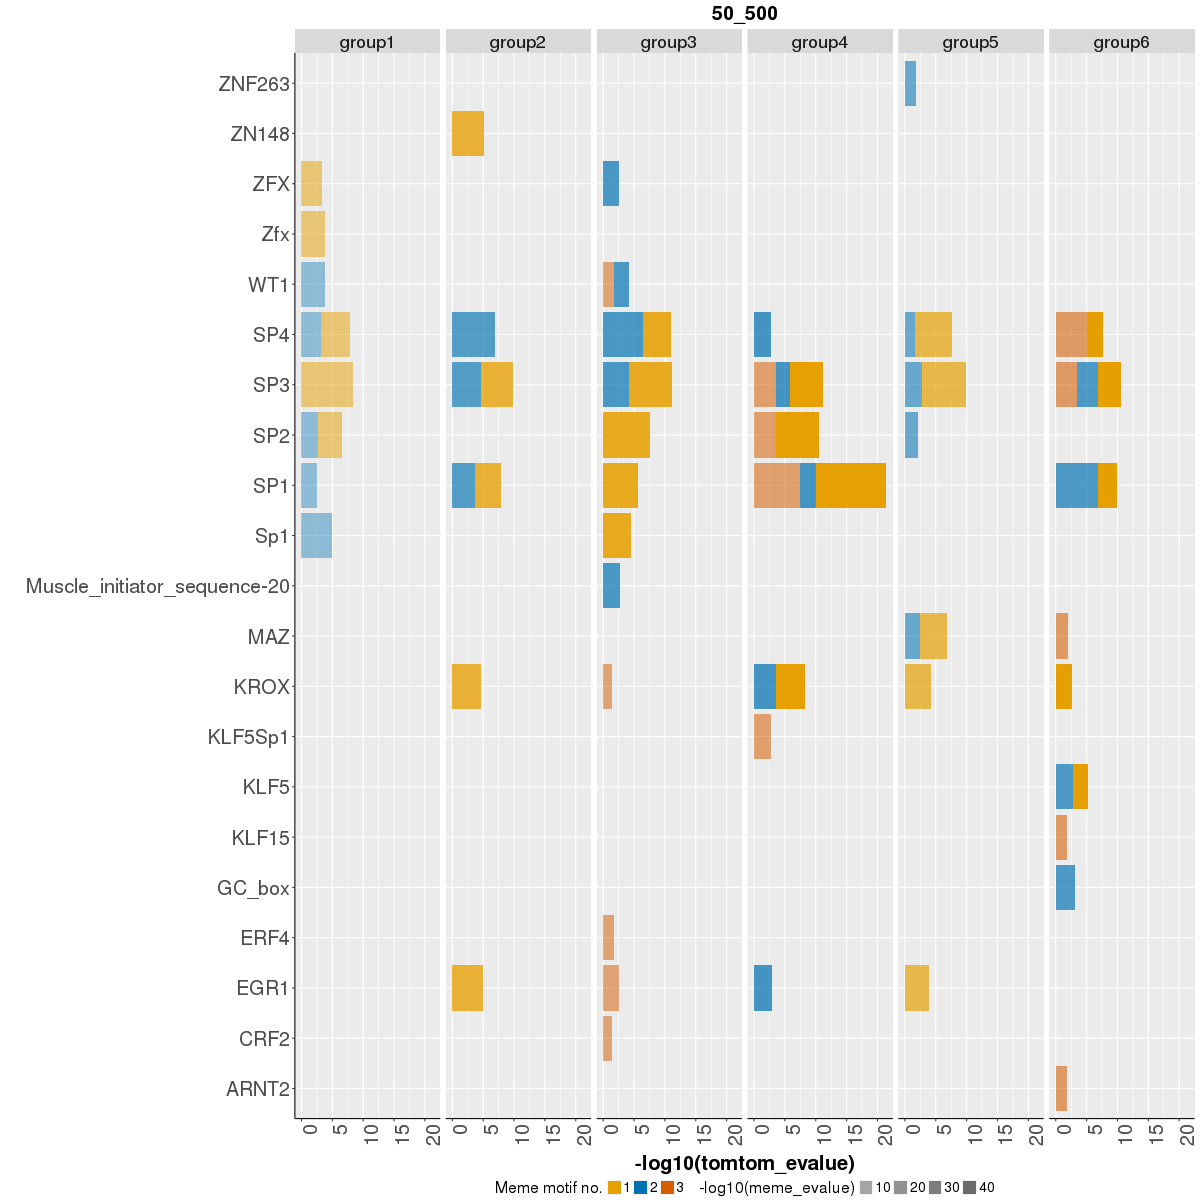

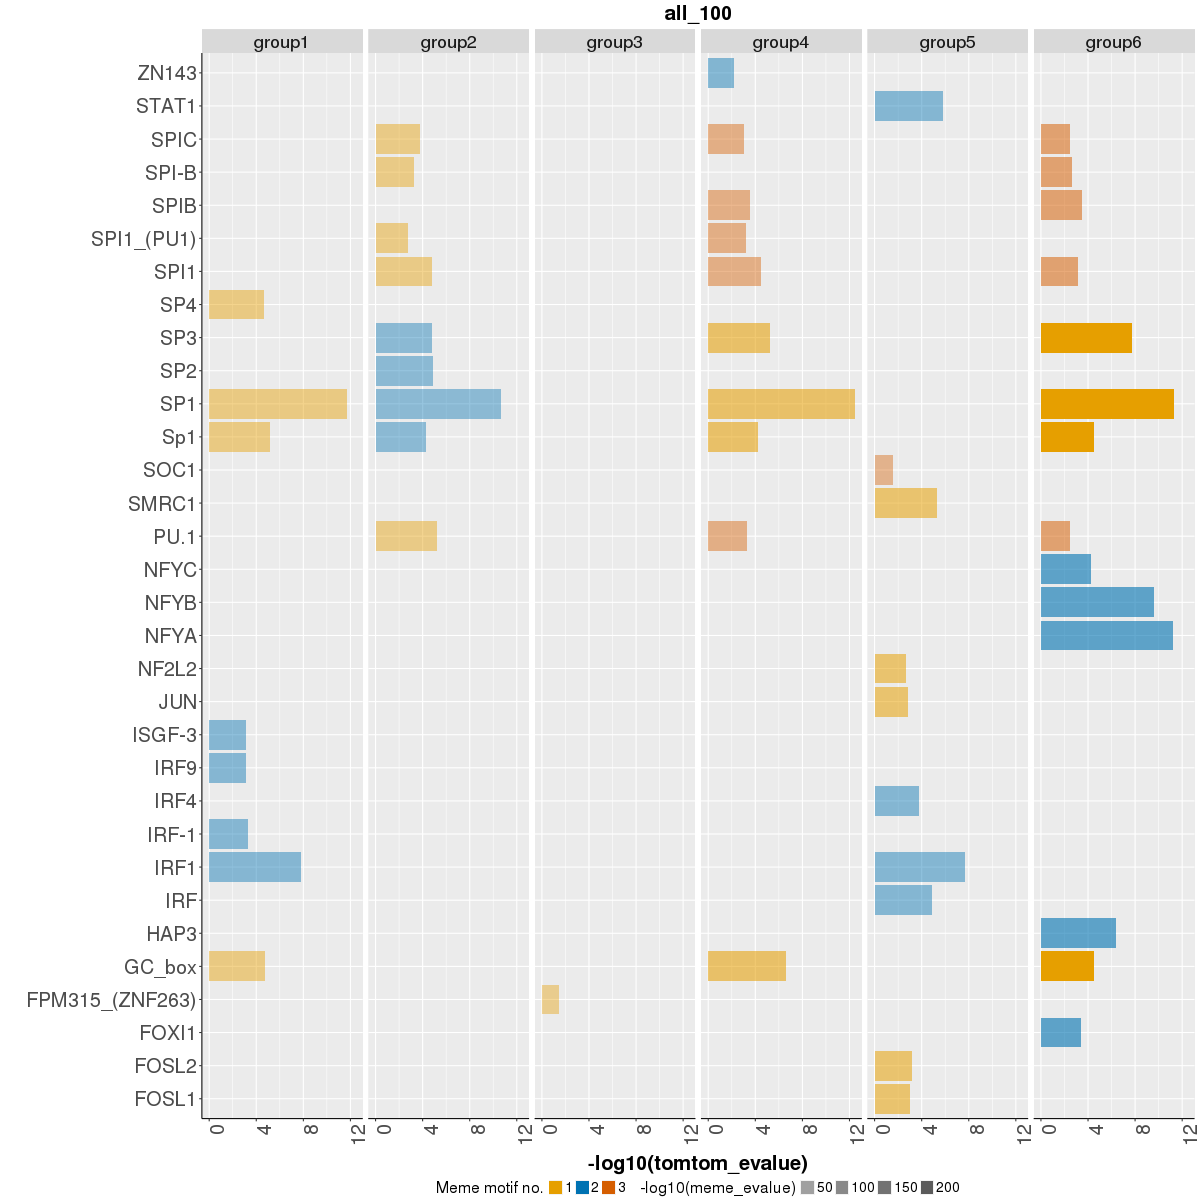

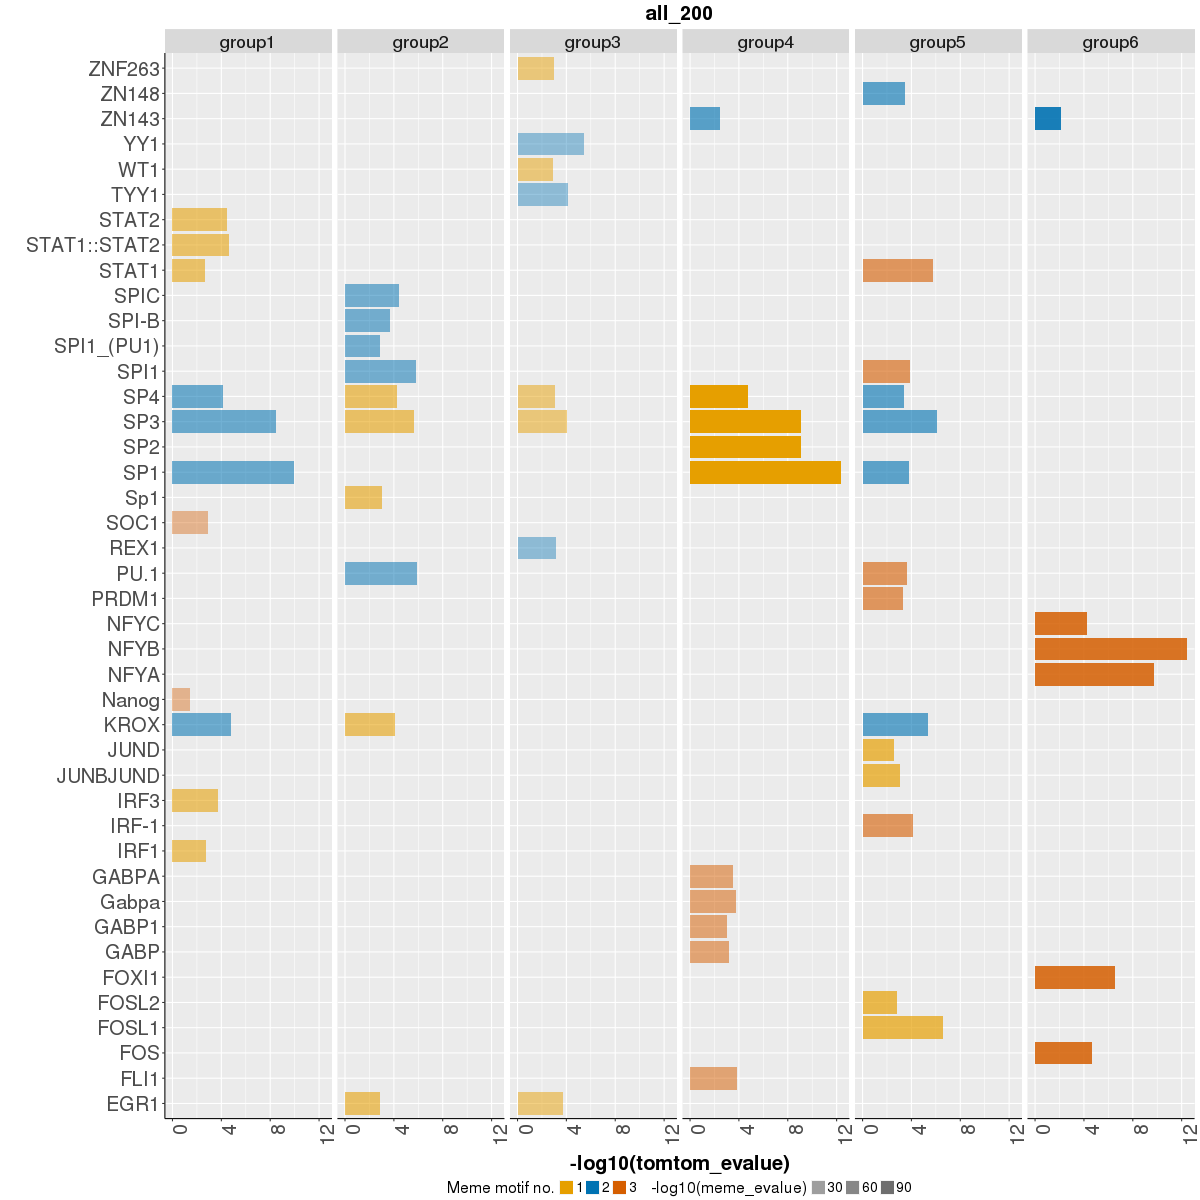

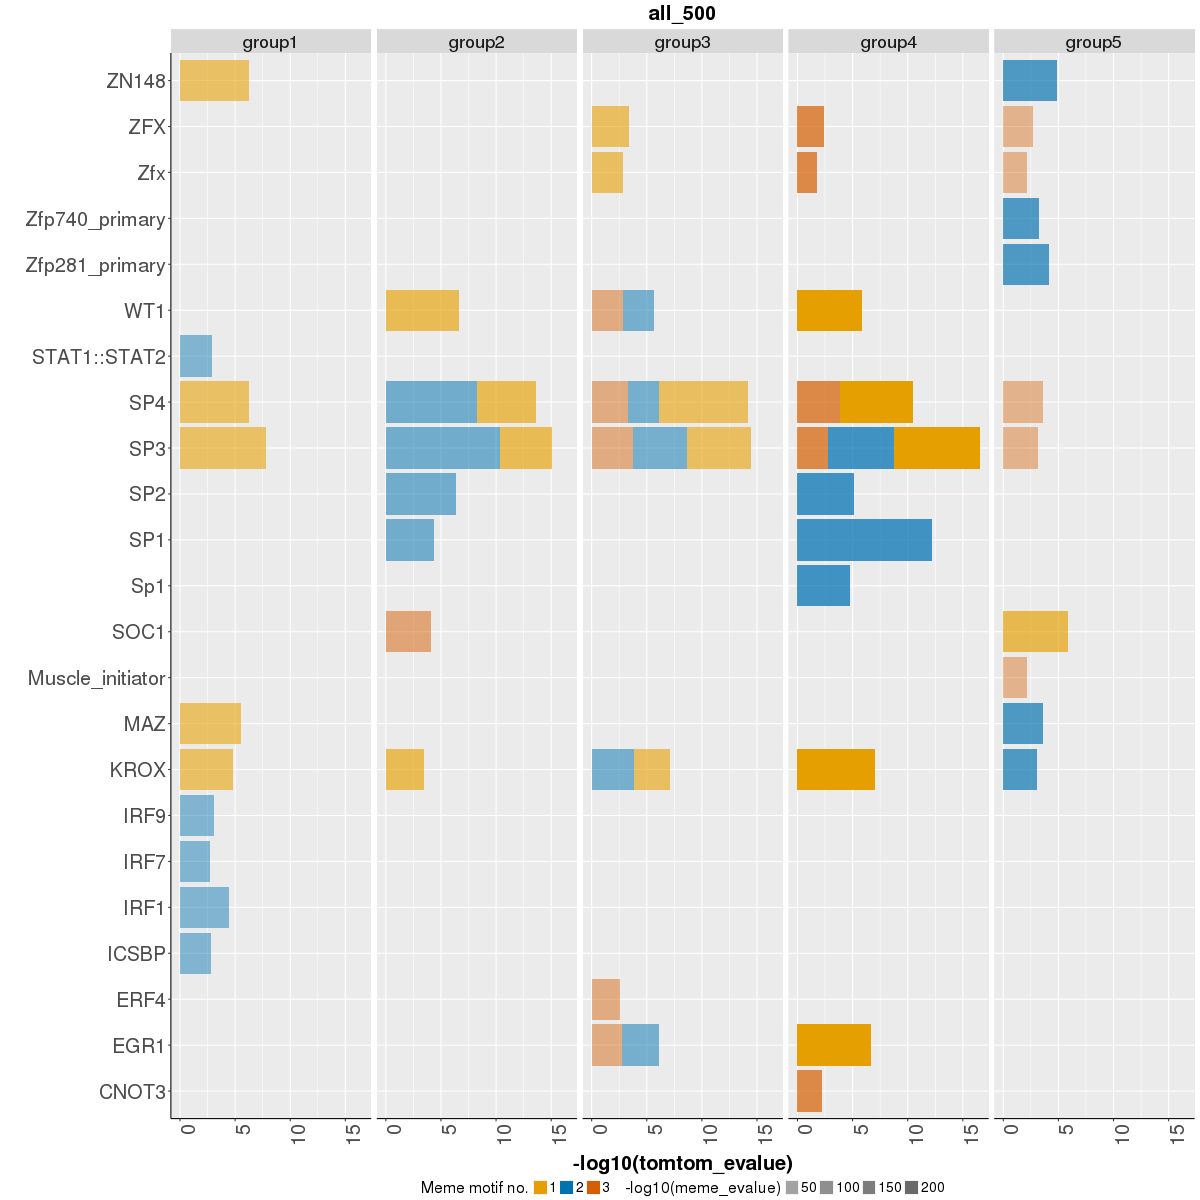

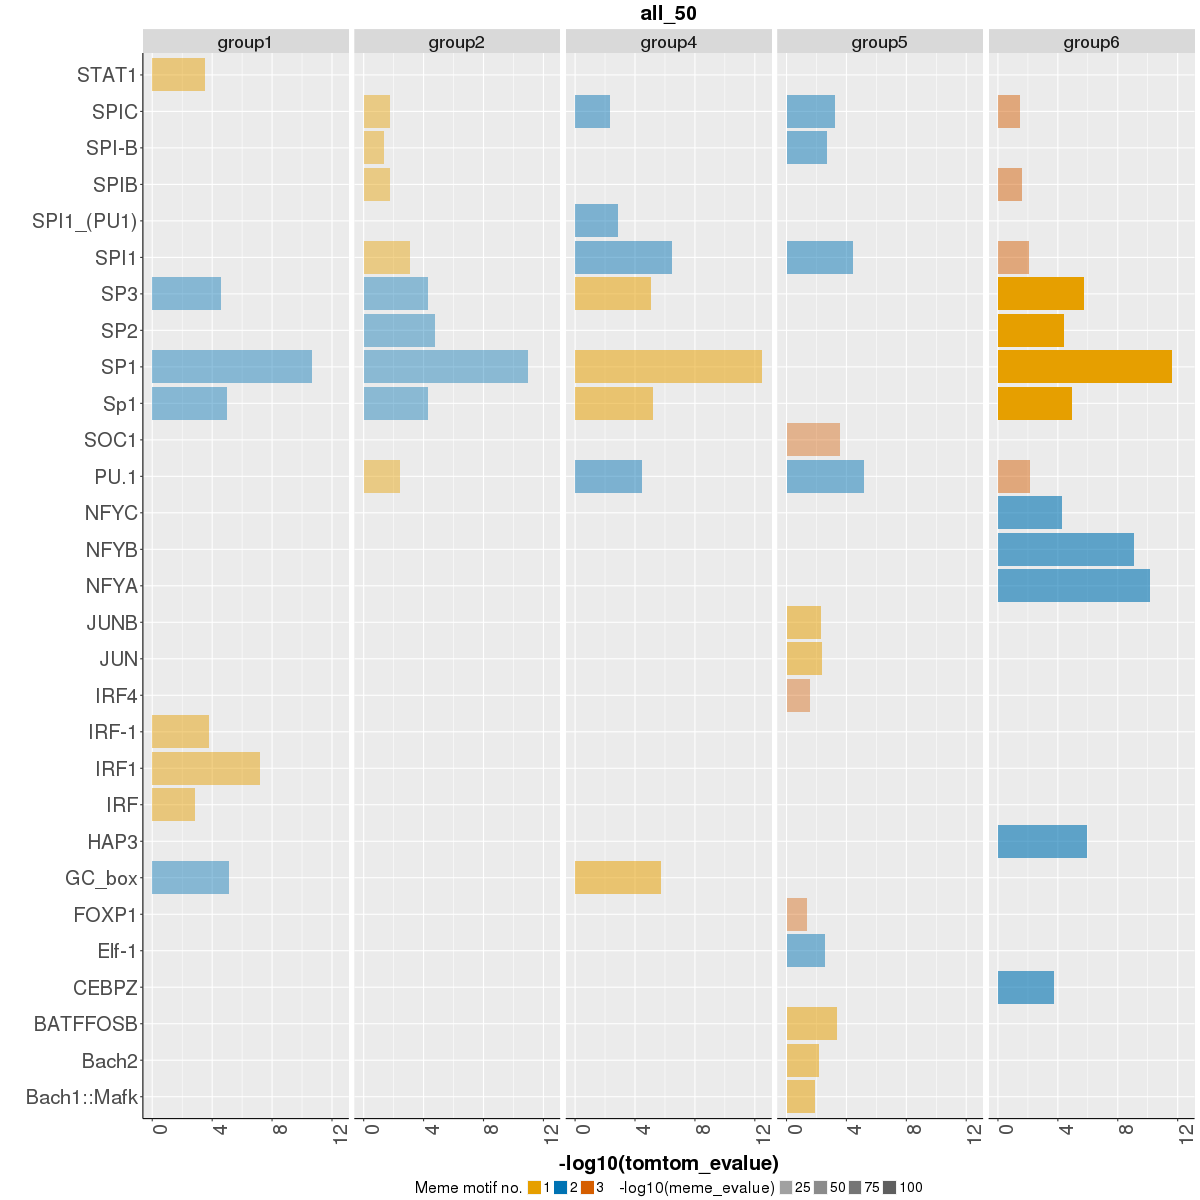

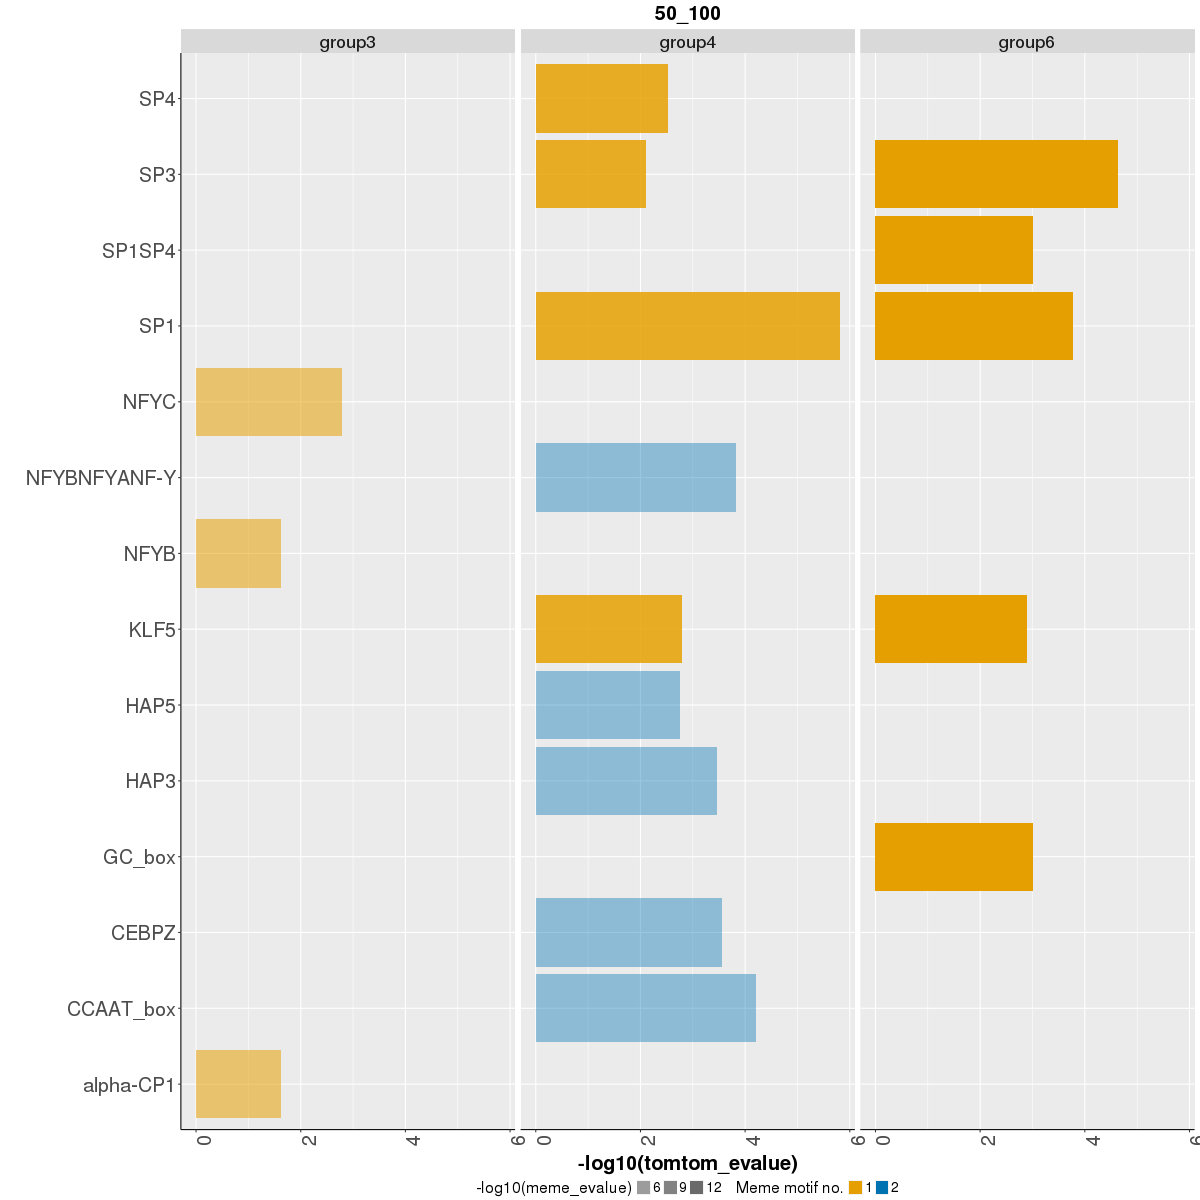

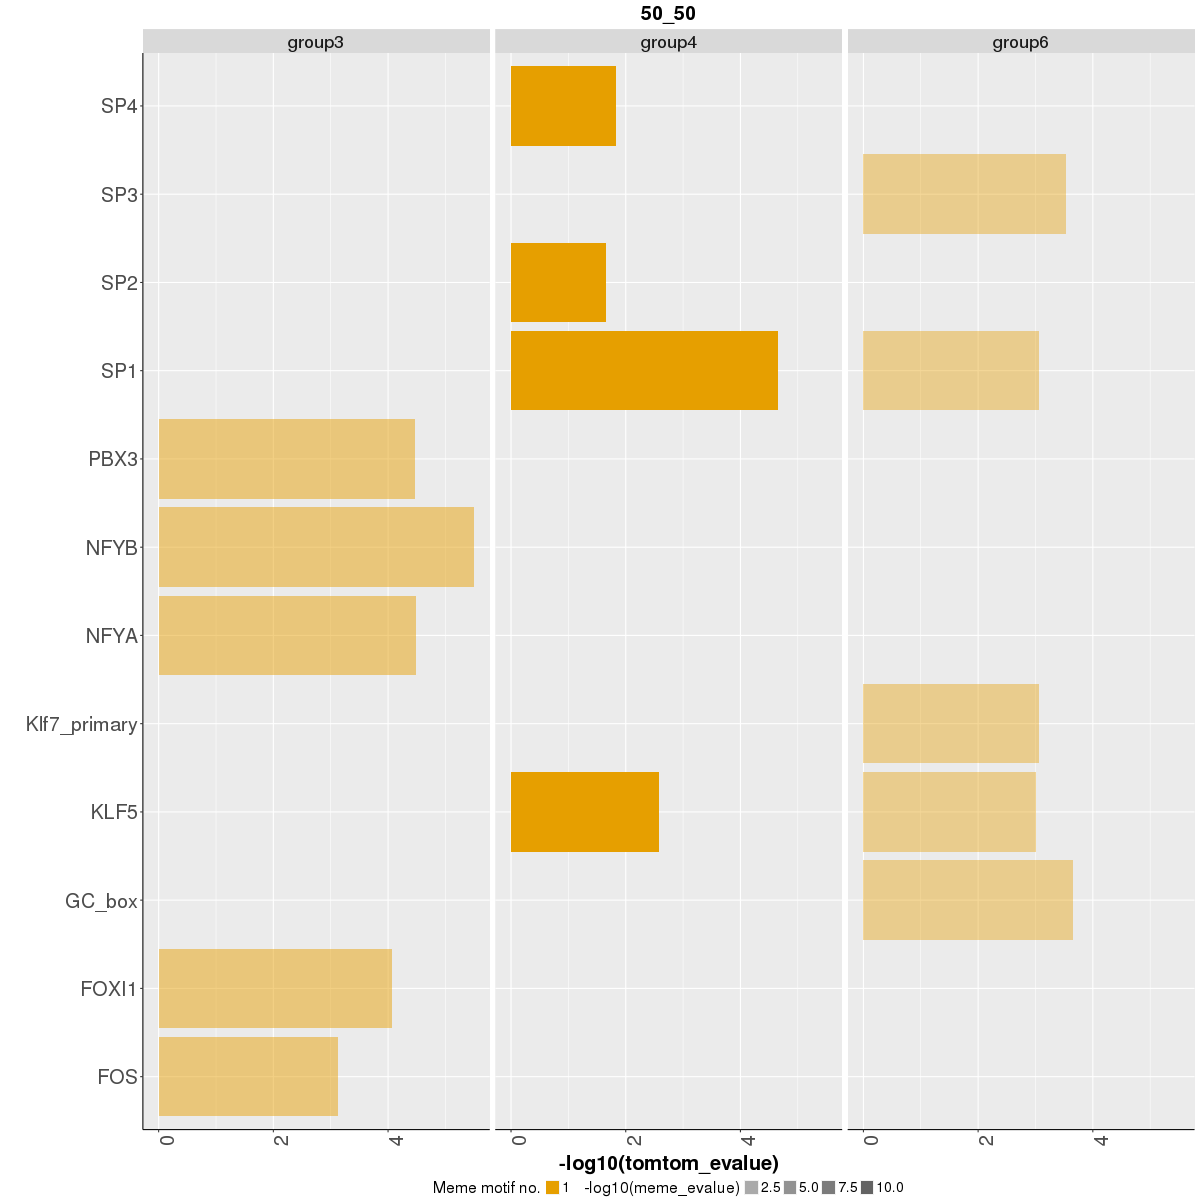

In [55]:
%%R -i tfs -w 1200 -h 1200

settings <- unique(tfs$settings)

for (setting in settings){
    p <- ggplot(subset(tfs, settings == setting), 
                aes(y=-log10(tomtom_evalue), x=motif_name, fill=query_id, alpha=-log10(meme_evalue))) + 
            geom_bar(stat="identity") + 
            coord_flip() +
            scale_alpha(range=c(0.4, 1)) + 
            facet_wrap( ~ DESeq2_comparison, nrow=1) +
            theme(axis.text.x=element_text(angle=90, hjust=1)) +
            scale_fill_manual(values=Palette, name = "Meme motif no.") +
            theme(legend.position="bottom", legend.direction="horizontal") +
            labs(title=setting, x="")

    grid.arrange(p, ncol=1, nrow=1)
}


<br>
## Top Motif Tables:
* Sorted by TOMTOM e-value

In [102]:
if "condition" in meme_chip.columns:
    for i in meme_chip["DESeq2_comparison"].unique():
        print i + " - Peaks with increased accessibility"
        meme_chip[(meme_chip.DESeq2_comparison == i) & (meme_chip.condition == "increase")].sort_values(["tomtom_evalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(20)
        print " "
else:
     for i in meme_chip["DESeq2_comparison"].unique():
        print i + " (No sub condition)"
        meme_chip[meme_chip.DESeq2_comparison == i].sort_values(["tomtom_evalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(20)
        print " "

group3 (No sub condition)


,meme_evalue,merge,query_id,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,run,DESeq2_comparison,no_peaks,window,settings
4518,2.600000e-80,group3_500_500_1,1,GCGGGCGGGGCGGCGGCGCGGG,SP4_MOUSE.H10MO.D,SP4,hocomoco,7.171580e-09,+,group3_500_500,group3,500,500,500_500
4250,1.200000e-46,group3_100_500_3,3,CCCGGGCCCCGCCCCCCCCCCG,SP3_MOUSE.H10MO.B,SP3,hocomoco,1.388600e-08,-,group3_100_500,group3,100,500,100_500
3599,9.900000e-40,group3_50_500_1,1,GCGAGGGGGCGGGGCCTGGGCGGGGGGCGC,MA0516.1,SP2,jaspar,2.244470e-08,-,group3_50_500,group3,50,500,50_500
3601,9.900000e-40,group3_50_500_1,1,GCGAGGGGGCGGGGCCTGGGCGGGGGGCGC,SP3_MOUSE.H10MO.B,SP3,hocomoco,1.000190e-07,+,group3_50_500,group3,50,500,50_500
4252,1.200000e-46,group3_100_500_3,3,CCCGGGCCCCGCCCCCCCCCCG,MA0516.1,SP2,uniprobe,2.138140e-07,+,group3_100_500,group3,100,500,100_500
3698,2.500000e-25,group3_50_500_2,2,CGCCGCCCCCCCGCCCGCGGCCCCGCCCC,SP4_MOUSE.H10MO.D,SP4,hocomoco,3.130980e-07,-,group3_50_500,group3,50,500,50_500
3602,9.900000e-40,group3_50_500_1,1,GCGAGGGGGCGGGGCCTGGGCGGGGGGCGC,SP1_MOUSE.H10MO.S,SP1,hocomoco,2.226350e-06,+,group3_50_500,group3,50,500,50_500
3381,1.700000e-03,group3_50_50_1,1,AGCCAATCAGAG,NFYB_MOUSE.H10MO.A,NFYB,hocomoco,3.172860e-06,+,group3_50_50,group3,50,50,50_50
3879,4.200000e-06,group3_100_100_1,1,CTCCGATTGGCT,NFYB_MOUSE.H10MO.A,NFYB,hocomoco,4.028760e-06,-,group3_100_100,group3,100,100,100_100
3843,3.600000e-07,group3_100_50_1,1,CTTTGATTGGCT,PBX3_MOUSE.H10MO.A,PBX3,hocomoco,8.040160e-06,+,group3_100_50,group3,100,50,100_50


 
group1 (No sub condition)


,meme_evalue,merge,query_id,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,run,DESeq2_comparison,no_peaks,window,settings
757,1.800000e-04,group1_100_200_2,2,GGGGGAGGGGGCGGGGCCGCGG,SP3_MOUSE.H10MO.B,SP3,hocomoco,6.529560e-11,+,group1_100_200,group1,100,200,100_200
1518,3.800000e-31,group1_500_200_2,2,CCCCCGCCCCGCCCCC,SP3_MOUSE.H10MO.B,SP3,hocomoco,3.499460e-09,-,group1_500_200,group1,500,200,500_200
852,2.500000e-33,group1_100_500_1,1,GGGGGCGGCGCGGGGGGCGGCGGGGCGGGG,SP4_MOUSE.H10MO.D,SP4,hocomoco,9.208790e-08,+,group1_100_500,group1,100,500,100_500
758,1.800000e-04,group1_100_200_2,2,GGGGGAGGGGGCGGGGCCGCGG,MA0516.1,SP2,jaspar,1.633990e-07,-,group1_100_200,group1,100,200,100_200
2798,1.400000e-20,group1_all_100_1,1,AGGGGGCGGGGC,SP1_MOUSE.H10MO.S,SP1,hocomoco,1.935520e-07,+,group1_all_100,group1,all,100,all_100
3183,7.900000e-75,group1_all_500_1,1,CCCCCGCCCCCTCCCCCCCCCC,SP4_MOUSE.H10MO.D,SP4,hocomoco,5.324320e-07,-,group1_all_500,group1,all,500,all_500
1636,7.900000e-75,group1_500_500_1,1,CCCCCGCCCCCTCCCCCCCCCC,ZN148_MOUSE.H10MO.D,ZN148,hocomoco,5.655060e-07,-,group1_500_500,group1,500,500,500_500
606,6.000000e-03,group1_100_100_2,2,CCCGGCCCCGCCCCCC,SP1_MOUSE.H10MO.S,SP1,hocomoco,7.088180e-07,-,group1_100_100,group1,100,100,100_100
946,8.300000e-23,group1_100_500_2,2,TTCAGTTTCGTTTCTC,STAT2_MOUSE.H10MO.B,STAT2,hocomoco,1.398060e-06,+,group1_100_500,group1,100,500,100_500
948,8.300000e-23,group1_100_500_2,2,TTCAGTTTCGTTTCTC,MA0517.1,STAT1::STAT2,uniprobe,2.708070e-06,+,group1_100_500,group1,100,500,100_500


***

In [100]:
if "condition" in meme_chip.columns:
    for i in meme_chip["DESeq2_comparison"].unique():
        print i + " - Peaks with decreased accessibility"
        meme_chip[(meme_chip.DESeq2_comparison == i) & (meme_chip.condition == "decrease")].sort_values(["tomtom_evalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(10)